In [45]:
import networkx as nx
from tqdm import tqdm
import random
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.colors import TwoSlopeNorm
import warnings
import numpy as np
import pandas as pd
import regex as re
import copy
import pickle
import community as community_louvain
import seaborn as sns
import os
import ast
from collections import defaultdict
from wordcloud import WordCloud

DATA_PATH = 'data/'

# Preprocessing

## Preprocess the two book dataframes
In this section we create a single dataframe containing descriptions of books, their genres, their titles and their ID in the shelf database. To do this we combine a dataframe containing the titles and the ID's with another containing titles, genres and descriptions. These are combined comparing the titles. The pipeline is as follows: 
- Load dataframes (*book_ID_df* gotten from *https://sites.google.com/eng.ucsd.edu/ucsdbookgraph/home* and *descriptions_df* gotten from *https://github.com/malcolmosh/goodbooks-10k-extended/blob/master/README.md*)
- Remove faulty elements of dataframe - the ones without a description
- Remove "additions" to titles in the description dataframes: "title (series #1)" -> "title". Example: "Catching Fire (The Hunger Games #1)" -> "Catching Fire"
- Make a new dataframe that contains *Book ID* and *Book Title* from *book_ID_df*, and *Genres* and *Description* from *descriptions_df*
- Store this dataframe

In [46]:
# Load dataframes
descriptions_df = pd.read_csv(DATA_PATH + "books_descriptions.csv")
book_ID_df = pd.read_json(DATA_PATH + 'goodreads_book_works.json', lines=True)

# Remove columns that are not needed in book_ID_df
book_ID_df = book_ID_df.filter(items=["best_book_id", "original_title", "reviews_count"])

In [47]:
# Remove faulty elements from the description dataframe
full_descriptions_df_size = len(descriptions_df)
descriptions_df = descriptions_df[descriptions_df['description'].apply(lambda x: isinstance(x, str))]

# Remove faulty elements from the book_ID_df
full_book_ID_df_size = len(book_ID_df)
book_ID_df = book_ID_df[book_ID_df['original_title'] != '']

In [48]:
# Remove "additions" to titles in the descriptions_df
for i, row in tqdm(descriptions_df.iterrows(), total = len(descriptions_df)):
    original_title = row["title"]
    new_title = re.sub(r'\((.*)', '', original_title)
    descriptions_df.at[i, "title"] = new_title.strip()

100%|██████████| 9943/9943 [00:00<00:00, 18294.61it/s]


In [49]:
# Lower case all titles to not have confusion in this manner
descriptions_df['title'] = descriptions_df['title'].str.lower()
book_ID_df['original_title'] = book_ID_df['original_title'].str.lower()

In [50]:
# Find corresponding indexes to merge the dataframes
warnings.simplefilter(action='ignore', category=FutureWarning)
titles_not_found = []
book_df = pd.DataFrame(columns=['book_id', 'title', 'description', 'genres'])

for i, row in tqdm(descriptions_df.iterrows(), total = descriptions_df.shape[0]):
    title = row['title']
    # Check if the title is in book_ID_df, else append it to the titles_not_found list
    if title in book_ID_df['original_title'].values:
        # Get all rows that have the a matching title as the current row
        temp_df = book_ID_df[book_ID_df['original_title'] == title]

        # Get the book id of the book  with the highest amount of reviews
        book_id = temp_df['best_book_id'][temp_df['reviews_count'].idxmax()]
        descriptions = row['description']
        genres = row['genres']
        book_df = book_df.append({'book_id': book_id, 'title': title, 'description': descriptions, 'genres': genres}, ignore_index=True)
    else:
        titles_not_found.append(title)

# Somehow the same book appears multiple times, hence we drop the duplicates
full_size_book_df_size = len(book_df)
book_df.drop_duplicates(subset=['title'], inplace=True)
print()

100%|██████████| 9943/9943 [06:53<00:00, 24.03it/s]

In [51]:
# This is the amount of books we start with in each dataframe
print("We start with this amount of books in each dataframe")
print(f"Amount of books in descriptions_df: {len(descriptions_df)}")
print(f"Amount of books in book_ID_df: {len(book_ID_df)}")
print(" ")

# This is the amount of books 
print("We then remove the faulty elements in each dataframe, and end up with this amount of remaining books")
print(f"Amount of books in descriptions_df: {len(descriptions_df)}. \nAmount of elements removed: {full_descriptions_df_size - len(descriptions_df)}")
print(f"Amount of books in book_ID_df: {len(book_ID_df)}. \nAmount of elements removed: {full_book_ID_df_size - len(book_ID_df)}")
print(" ")

# print the amount of elements that are not found")
print(f"Out of the {len(descriptions_df)} titles {len(titles_not_found)} are not found in the book_ID_df")
print(f"This results in {len(book_df)} titles in the final dataset")

We start with this amount of books in each dataframe
Amount of books in descriptions_df: 9943
Amount of books in book_ID_df: 646906
 
We then remove the faulty elements in each dataframe, and end up with this amount of remaining books
Amount of books in descriptions_df: 9943. 
Amount of elements removed: 57
Amount of books in book_ID_df: 646906. 
Amount of elements removed: 875056
 
Out of the 9943 titles 2061 are not found in the book_ID_df
This results in 7691 titles in the final dataset


This results in a dataframe of 7691 different books. We call this dataframe *book_df*.

## Preprocess the shelves
Now we create the subset of the shelf dataset that we need. We simply drop all elements that do not concern the books we have descriptions of. 
- Find the  corresponding ID's to the books in *book_df* with the *book_id_map.csv* and store these instead. These are the ID's relevant to the shelves.
- Drop all rows in *goodreads_interactions.csv* that have different ID's than the ones in *book_df*.
- Store this dataset.

In [52]:
# Load dataframes
book_id_map_df = pd.read_csv(DATA_PATH + "book_id_map.csv")
book_df = pd.read_csv(DATA_PATH + "book_df.csv")

In [53]:
# Create map from book_id to book_id_csv
book_id_map = {book_id_map_df['book_id'][i]: book_id_map_df['book_id_csv'][i] for i in range(len(book_id_map_df))}

# Change the book ID in our dataset to match the shelf dataset
remove_list = [] # remove about 15 books that are for inexplicable reasons not in the shelf dataset
for i in range(len(book_df)):
    try:
        book_df["book_id"][i] = book_id_map[book_df["book_id"][i]]
    except:
        remove_list.append(i)
print(f"Out of {len(book_df)} books {len(remove_list)} are not in the shelf dataset and hence removed")
book_df.drop(remove_list, inplace=True)

# Save the book_df dataframe with the index change
book_df.to_csv(DATA_PATH + 'book_matching_ids_df.csv', index=False)

<ipython-input-53-c7b2552b9003>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  book_df["book_id"][i] = book_id_map[book_df["book_id"][i]]


Out of 7691 books 15 are not in the shelf dataset and hence removed


In [54]:
# Load the shelves dataframe (this takes some time and memory)
shelves_df = pd.read_csv(DATA_PATH + "goodreads_interactions.csv")
# Store shelf entries amount 
shelf_entries = len(shelves_df)

# Remove books on the shelves that are not in the book_df
shelves_df = shelves_df[shelves_df['book_id'].isin(book_df['book_id'].tolist())]

# Save the new shelves_df
shelves_df.to_csv(DATA_PATH + 'shelves_df.csv', index=False)

In [55]:
# Remove books that are not on any shelves. 
books_in_shelves = set(shelves_df['book_id'].tolist())
book_df = book_df[book_df['book_id'].isin(books_in_shelves)]

# Save the book_df dataframe with the index change
book_df.to_csv(DATA_PATH + 'book_matching_ids_df.csv', index=False)

In [96]:
# Check how many books are on the shelves of ALL users combined
print(f'There are {shelf_entries} interactions (a book on a shelf) in total in the interaction dataset.')
# Check how many books are on the shelves of ALL users combined - after removal of books not in book_df
print(f"We have {len(shelves_df)} interactions of books with descriptions, and in these there are {len(books_in_shelves)} unique books. Hence, we have removed {len(descriptions_df) - len(books_in_shelves)} books from the book_df.")

There are 228648342 interactions (a book on a shelf) in total in the interaction dataset.
We have 68176467 interactions of books with descriptions, and in these there are 7676 unique books. Hence, we have removed 2267 books from the book_df.


We have limited our original interactions dataset to a smaller one containing 68176467 interactions, and limited our book dataset to 7676 books. 

## TF-IDF embeddings
In this section we create the TF-IDF (Term Frequency - Inverse Document Frequency) vectors for each book. These are stored in *TF_book_df.csv*, *IDF_dict.npy* and *TF_IDF_book_df.csv*.
- First we clean and tokenize the descriptions of each book
- Next, we create a TF value matrix for the entire dataset 
- This matrix is used to create the IDF values and the TF-IDF values 

At last we compute the TF-IDF values of each genre. This is its own subsection and the process is described then. 

In [57]:
# imports for the text analysis
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords
import re
import ast

# Import the book description dataframe
book_df = pd.read_csv(DATA_PATH + "book_matching_ids_df.csv")

# Logorithmic scale chosen for IDF
BASE = 2

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\david\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\david\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [58]:
# Function to clean strings (from week 7)
def clean_strings(strings):
    """ Cleans a list of strings by removing URLs, numbers, punctuation and stop words

    Args:
    - strings: a list of strings

    returns:
    - cleaned_strings: a list of cleaned strings
    """
    cleaned_strings = []
    stop_words = set(stopwords.words('english'))

    for string in strings:
        # Remove URLs
        string = re.sub(r'http\S+', '', string)

        # Remove numbers
        string = re.sub(r'[0-9]', '', string)

        # Keep only what is not punctuation
        string = re.sub(r'[^\w\s]', '', string)

        # Lowercase
        string = string.lower()

        # Remove empty strings and remove stop words and moke them
        if len(string) and string not in stop_words and type(string) == str:
            cleaned_strings.append(string)

    return cleaned_strings


In [59]:
# Create tokens from descriptions
# If the dataframe has not yet gotten the tokens, do it here and save it
if not 'tokens' in book_df.columns:
    book_df['tokens'] = None
    for i, row in tqdm(book_df.iterrows(), total = book_df.shape[0]):
        description = row['description']
        # If the description is not a string, it is probably a NaN, so we set it to None
        if type(description) == str:
            tokens = nltk.word_tokenize(description)
            clean_tokens = clean_strings(tokens)
            book_df['tokens'][i] = clean_tokens # str(clean_tokens)

    book_df.to_csv(DATA_PATH + 'book_matching_ids_df.csv', index=False)
else:
    if type(book_df['tokens'][0]) == str:
        book_df['tokens'] = book_df['tokens'].apply(ast.literal_eval)
    else: 
        pass


  0%|          | 0/7676 [00:00<?, ?it/s]<ipython-input-59-d4b23152b85f>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  book_df['tokens'][i] = clean_tokens # str(clean_tokens)
100%|██████████| 7676/7676 [00:11<00:00, 674.30it/s]


In [60]:
# Calculate the tf scores for each community (from the previous weeks)
def TF_from_corpus(corpus):
    """ Calculates the TF scores for each word in the corpus

    Args:
        corpus (list): list of lists of words/strings

    Returns:
        TF_df (pandas.DataFrame): Dataframe containing the TF scores for each word in the corpus
    """
    # Create empty dictionary to keep track of word counts
    word_counts = {}
    n_communities = len(corpus)

    # Iterate through all communities
    for i, document in tqdm(enumerate(corpus), total=n_communities):
        # Iterate through each word in the current sublist
        for word in document:
            # If the current word is not in the dictionary, add it with a list of zeros
            if word not in word_counts:
                word_counts[word] = [0] * n_communities

            # Increment count for the current word and list index
            word_counts[word][i] += 1

    # Create pandas dataframe from the word_counts dictionary
    TF_df = pd.DataFrame.from_dict(word_counts).transpose()

    return TF_df


In [61]:
# Function that takes in a TF and an IDF and computes the TF_IDF dataframe (from the previous weeks)
def make_TF_IDF(TF_df, IDF_dict):
    """Multiply the TF and IDF scores to get the TF-IDF scores

    Args:
        TF_df (pandas.DataFrame): Dataframe containing the TF scores for each word in the corpus
        IDF_dict (dict): Dictionary containing the IDF scores for each word in the corpus

    Returns:
        TF_IDF (pandas.DataFrame): Dataframe containing the TF-IDF scores for each word in the corpus
    """
    # Create the TF-IDF dataframe
    TF_IDF = pd.DataFrame(index=TF_df.index, columns=TF_df.columns)

    # iterate over the index of the DataFrame
    for word in tqdm(TF_df.index, total=TF_df.shape[0]):
        # multiply the values by the IDF_dict value
        TF_IDF.loc[word] = TF_df.loc[word] * IDF_dict[word]


    return TF_IDF


In [62]:
# Load the TF dataframe for the corpus if possible, else create it
try:
    TF_book_df = pd.read_csv(DATA_PATH + "TF_book_df.csv", index_col=0)
except:
    # Create it
    TF_book_df = TF_from_corpus(book_df['tokens'])

    # Rename the columns to the book_ids
    TF_book_df.columns = book_df['book_id'].tolist()

    # Save the TF dataframe
    TF_book_df.to_csv(DATA_PATH + "TF_book_df.csv")

In [63]:
# Create the total token count "T_all_books" and the IDF score for each book "IDF_book_dict"
try:
    IDF_dict = np.load(DATA_PATH + 'IDF_dict.npy', allow_pickle=True).item()
except:
    T_all_books = TF_book_df.apply(lambda row: (row != 0).sum(), axis=1)
    # The log BASE is chosen when loading the libraries
    IDF_dict = {word: np.emath.logn(BASE, len(TF_book_df.columns)/ T_all_books[word]) for word in TF_book_df.index}

    np.save(DATA_PATH + 'IDF_dict.npy', IDF_dict)

In [64]:
# Create the TF-IDF scores for each book "TF_IDF_book_df" if it has not already been made
try:
    TF_IDF_book_df = pd.read_csv(DATA_PATH + "TF_IDF_book_df.csv", index_col=0)
except:
    # Create the dataframe
    TF_IDF_book_df = make_TF_IDF(TF_book_df, IDF_dict)

    # Save the dataframe
    TF_IDF_book_df.to_csv(DATA_PATH + "TF_IDF_book_df.csv")

### Genre TF and TF-IDF scores
We cluster together all books containing each genre and sum their TF values to get the TF value of each genre. Then we compute the IDF and TF-IDF as usual. 
- Create groups of books corresponding to gernes. 
- Create TF vectors by summing the TF vectors of the books.
- Create IDF and TF-IDF as usual. (we only store the TF-IDF vectors as they are the only important one for our analysis)

In [65]:
# Find the set of genres
genres = set()
for i in book_df["genres"].to_list():
    genres = genres.union(set(ast.literal_eval(i)))

In [66]:
# Try to load the TF_genres_df, else create it
try:
    # Load the TF_genres_df
    TF_genres_df = pd.read_csv(DATA_PATH + "TF_genres_df.csv", index_col=0)
except:
    # For each genre, sum all TF scores for books in that genre
    TF_genres_df = pd.DataFrame(index=TF_book_df.index, columns=genres)

    TF_genres_df = TF_genres_df.fillna(0)

    # Go through all books and add the TF scores to the genres of the book
    for i, row in tqdm(book_df.iterrows()):
        for genre in ast.literal_eval(row['genres']):
            TF_genres_df[genre] = TF_genres_df[genre] + TF_book_df[row['book_id']]

    # Save the genres_TF_df
    TF_genres_df.to_csv(DATA_PATH + "TF_genres_df.csv")

In [67]:
# Try to load the TF_IDF_genres_df, else create it
try:
    # Load the TF_IDF_genres_df
    TF_IDF_genres_df = pd.read_csv(DATA_PATH + "TF_IDF_genres_df.csv", index_col=0)
except:
    # Count every time a word appears in a new genre. 
    T_all_genres = TF_genres_df.apply(lambda row: (row != 0).sum(), axis=1)
    
    # Get the IDF values for the genres
    IDF_genres_dict = {word: np.emath.logn(BASE, len(TF_genres_df.columns)/ T_all_genres[word]) for word in TF_genres_df.index}

    # Create the dataframe for the TF-IDF scores for the genres
    TF_IDF_genres_df = make_TF_IDF(TF_genres_df, IDF_genres_dict)

    # Save the dataframe
    TF_IDF_genres_df.to_csv(DATA_PATH + "TF_IDF_genres_df.csv")

## Create a genre for each book
Later in our analysis it will be preferable to have one and only one genre for each book. We therefore create the a *top_genre* for each book, which is the gerne that the book's description is most similar to. This is calculated by taking the normalized inner product between the book's TF-IDF vector and each the TF-IDF vector of each genre that the book has. The maximum is then chosen. We must use the normalized inner product, because two genres might have different lengths, and hence the inner product will be larger. 
- Calculate the normalized inner product between each book and its genres. 
- Choose the largest of these to be the *top_genre*.

In [68]:
# Inner product function
def inner_product(v1, v2):
    """Calculates the normed inner product of two vectors

    Args:
        v1 (list): list of numbers
        v2 (list): list of numbers

    Returns:
        inner_product (float): inner product of the two vectors (divided by the product of their norms)
    """

    return np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2))


In [69]:
# Generate genre by taking inner products between each book and each genre of that book, and choosing the maximal
def get_genres(book_df, TF_IDF_genres_df, TF_IDF_book_df):
    # TODO: Check these args and return
    """
    Args:
        book_df (DataFrame): DataFrame with genres for each book
        TF_IDF_genres_df (DataFrame): DataFrame with TF_IDF each genre
        TF_IDF_book_df (DataFrame): DataFrame with TF_IDF each book

    Returns:
        genres (dict): Dictionary with book ids as keys and the corresponding gerne that matches the best
    """

    # Create a dictionary to store the genre for each book
    genres = {}

    # Go through each book
    for i, row in tqdm(book_df.iterrows(), total = len(book_df)):
        # Get the TF-IDF scores for the current book
        book_TF_IDF = TF_IDF_book_df[str(row["book_id"])]

        best_genre = (None, 0)

        # Go through each genre of the book
        for genre in ast.literal_eval(row['genres']):
            genre_TF_IDF = TF_IDF_genres_df[genre]
            # print(f"inner_product {inner_product(book_TF_IDF, genre_TF_IDF)} {genre}") # Testing
            if inner_product(book_TF_IDF, genre_TF_IDF) > best_genre[1]:
                best_genre = (genre, inner_product(book_TF_IDF, genre_TF_IDF))
        # print(best_genre) # Testing
        # break # Testing
        # Save the best genre
        genres[row["book_id"]] = best_genre[0]

    return genres


In [70]:
# Get the genres for each book
genres = get_genres(book_df, TF_IDF_genres_df, TF_IDF_book_df)

book_df["top_genre"] = book_df["book_id"].map(genres)

# Save the book_df as complete_book_df
book_df.to_csv(DATA_PATH + "complete_book_df.csv")


100%|██████████| 7676/7676 [00:05<00:00, 1481.28it/s]


In [71]:
print(f'A dataframe with the combined datasets and with a top genre for each book, made by comparing TF_IDF vectors.\nAn example of a row is,')
print(f'title: {book_df[book_df["book_id"] == 536]["title"].item()}, top_genre: {book_df[book_df["book_id"] == 536]["top_genre"].item()}, genres: {book_df[book_df["book_id"] == 536]["genres"].item()}')

A dataframe with the combined datasets and with a top genre for each book, made by comparing TF_IDF vectors.
An example of a row is,
title: the hunger games, top_genre: science-fiction, genres: ['young-adult', 'fiction', 'fantasy', 'science-fiction', 'romance']


# Creation of Shelf Graph 
The Shelf Graph consists of books as nodes, and has a weighted edge between two nodes if both of the books appear together on enough users shelves. The aim of the Shelf Graph is to figure out which books are usually read together.  

## Raw Graph 
To create the Shelf Graph, we need to go through all shelves and count each time an edge appears (each time both books are in the same shelf). This is a very time consuming task, because we have 7676 books, and there are therefore, 
$$\frac{7676^2 - 7676}{2} = 29,456,650$$
possible edges. If not run before, the counting of when each pair of books occur takes about 12 hours on a moderately fast PC. 

In [72]:
# Create the shelf edges and store them (this takes about 12 hours)
shelves_df = pd.read_csv(DATA_PATH + 'shelves_df.csv')
# Collapse into shelves
imploded_df = shelves_df.groupby('user_id')['book_id'].apply(list).reset_index()

# Count occurrences of each book
book_counts = {}
for i, shelf in tqdm(imploded_df.iterrows(), total=imploded_df.shape[0]):
    for book in shelf['book_id']:
        if book in book_counts:
            book_counts[book] += 1
        else:
            book_counts[book] = 1

# Count appearances of pairs of books
try:
    edges_original = np.load(DATA_PATH + "shelf_edges.npy", allow_pickle=True).item()
except:
    edges_original = {}
    for i, shelf in tqdm(imploded_df.iterrows(), total=imploded_df.shape[0]):
        if len(shelf['book_id']) > 1:
            # Generate pairs of books
            for i in range(len(shelf['book_id'])):
                for j in range(i+1, len(shelf['book_id'])):
                    # Create edge
                    edge = frozenset([shelf['book_id'][i], shelf['book_id'][j]])
                    # Add edge to dictionary
                    if edge in edges_original:
                        edges_original[edge] += 1
                    else:
                        edges_original[edge] = 1
    np.save(DATA_PATH + "shelf_edges.npy", edges_original)

100%|██████████| 818569/818569 [00:44<00:00, 18297.44it/s]


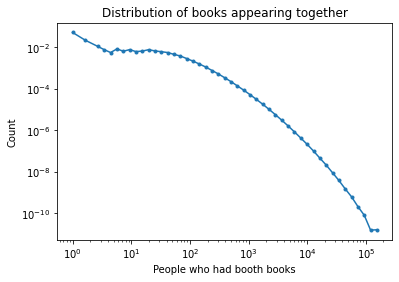

In [73]:
# Plot a histogram of the number of times each edge appears (log log scale)
bins = 50
data = list(edges_original.values())

# Calculate where the bins should be (logarithmically)
bins = np.logspace(np.log10(max(1, int(min(data)))), max(1, np.log10(np.ceil(max(data)) + int(max(data)/20))), bins)
hist, edges = np.histogram(data, bins = bins, density = True)
x_values = (edges[:-1] + edges[1:])/2

# Remove bins without any points in
x_values, hights = zip(*[(i,j) for (i,j) in zip(bins, hist) if j > 0])

# Create the plot
fig, ax = plt.subplots()
ax.plot(x_values, hights, '.-')
ax.set_xscale('log')
ax.set_yscale('log')
plt.xlabel('People who had booth books')
plt.ylabel('Count')
plt.title('Distribution of books appearing together')
plt.show()

In [74]:
print(f'The amount of users are: {len(imploded_df)}')
print(f'There are {len(edges_original)} edges in the network.')

The amount of users are: 818569
There are 28704535 edges in the network.


As seen, the graph is to dense, as there are 28,704,535 edges out of the possible 29,456,650. We therefore need to remove a lot of edges to make the network more sparse and informative. Looking at the distribution of the weight of the edges, it is almost powerlaw distributed as the plot above is close to a straight line and hence we can remove a large portion of the edges by removing the edges with low weights. The nature of the threshold will be explored in the next section. 

## Choice of threshold
We explored three different weightings for the edges.
- Purely appearances together
- Appearances together, divided by the square root of appearance counts of the two books.
- Appearances together, divided by the smallest appearance count of the two books.

#### Purely appearances together
The first method has the issue that books that appear more often in the dataset will be more likely to have appeared more times with the other books, hence, books that appear little will not be removed entirely from the if we use the first method of weighing. Therefore, we needed something more adaptive. 
<br>

####  Appearances together, divided by the square root of appearance counts of the two books.
In the second method the edge weights are given by, 

$$e_{book_i, book_j} = \frac{C_{book_i, book_j}}{\sqrt{C_{book_i} \cdot C_{book_j}}}.$$

This introduces a new issue, which is that if a book $book_{i}$ always appear together with $book_{j}$, but $book_{j}$  is much more frequent in the dataset, then the edge between these two books is small. This means that books that frequently appear in the dataset will always have small edge weights, and thus, will be removed if we set a threshhold. This is not ideal either, as *The Hunger Games* should probably always appear in shelves that have *Catching Fire* (the second Hunger Games book), but the other way around is probably not true, as people might not had read that far yet. These two books should definitly have a strong connection, as must users look at both. 
<br>

#### Appearances together, divided by the smallest appearance count of the two books.
This last method solves the above problem by only dividing with the smallest appearance counter $\min_{k\in\{i, j\}}{C_{book_k}}$, 
$$e_{book_i, book_j} = \frac{C_{book_i, book_j}}{\min_{k\in\{i, j\}}{C_{book_k}}}.$$
This is because all books have a chance of forming strong edges with all other books. Hence, this is the method we use. 

### Test of threshold size 
To evaluate if 0.5 is a possible threshold we try it, along with other thresholds, and observe how many books are completely dropped, and we look at the degree distribution. 

In [75]:
# For this analysis the variables needed are edges_original and book_counts
edges_weighted = edges_original.copy()

#For each edge divide the weight of it by the lowest appearance count of the two nodes it connects
for edge in tqdm(edges_weighted):
    edges_weighted[edge] = edges_weighted[edge] / min((book_counts[list(edge)[0]], book_counts[list(edge)[1]]))

# Save weighted edges
np.save(DATA_PATH + 'shelf_edges_weighted.npy', edges_weighted)

100%|██████████| 28704535/28704535 [00:29<00:00, 966986.60it/s] 


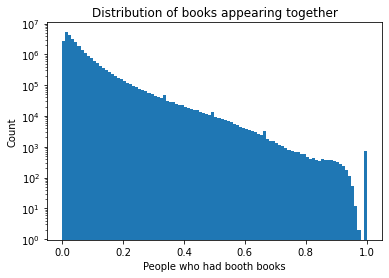

In [76]:
# Plot a histogram of the number of times each edge appears
plt.hist(edges_weighted.values(), log=True, bins=100)
plt.xlabel('People who had booth books')
plt.ylabel('Count')
plt.title('Distribution of books appearing together')
plt.show()

In [77]:
# Test different thresholds for the edges to visualize which works best
thresholds = [i/10 for i in range(1, 10)]
n_nodes = []
n_edges = []
degrees = []

# Go through each treshold (smallest first)
for threshold in thresholds:
    edges_threshold = {k: v for k, v in edges_weighted.items() if v >= threshold}

    # Store the corresponding number of nodes and edges
    nodes = {node for nodes in edges_threshold for node in nodes}
    n_nodes.append(len(nodes))
    n_edges.append(len(edges_threshold))
    degrees.append(len(edges_threshold)*2/len(nodes))

    print(f'For the threshold of {np.round(threshold,2)}:')
    print(f'The amount of edges is {len(edges_threshold)}, nodes: {len(nodes)} and the node/edges fraction is: {len(edges_threshold)*2/len(nodes)}')



For the threshold of 0.1:
The amount of edges is 4701266, nodes: 7674 and the node/edges fraction is: 1225.2452436799583
For the threshold of 0.2:
The amount of edges is 1463287, nodes: 7674 and the node/edges fraction is: 381.3622621839979
For the threshold of 0.3:
The amount of edges is 591722, nodes: 7674 and the node/edges fraction is: 154.21475110763618
For the threshold of 0.4:
The amount of edges is 256679, nodes: 7665 and the node/edges fraction is: 66.97429876060013
For the threshold of 0.5:
The amount of edges is 109627, nodes: 7539 and the node/edges fraction is: 29.08263695450325
For the threshold of 0.6:
The amount of edges is 41183, nodes: 6876 and the node/edges fraction is: 11.978766724840023
For the threshold of 0.7:
The amount of edges is 14293, nodes: 4651 and the node/edges fraction is: 6.146205117179101
For the threshold of 0.8:
The amount of edges is 5822, nodes: 2790 and the node/edges fraction is: 4.17347670250896
For the threshold of 0.9:
The amount of edges is

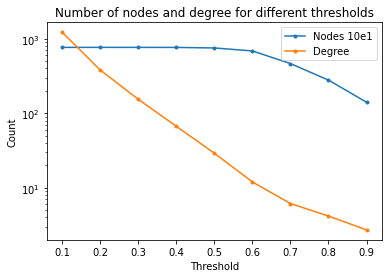

In [78]:
# Plot the number of nodes and edges for each threshold
fig, ax = plt.subplots()
n_nodes_10 = [i/10 for i in n_nodes]
ax.plot(thresholds, n_nodes_10, '.-', label='Nodes 10e1')
# ax.plot(thresholds, n_edges, label='Edges')
ax.plot(thresholds, degrees, '.-', label='Degree')
ax.set_yscale('log')
ax.set_xlabel('Threshold')
ax.set_ylabel('Count')
ax.set_title('Number of nodes and degree for different thresholds')
ax.legend()

The optimal threshold keeps the most possible books, while having a degree that is small enough to distinguish communities. We see that we should not make the threshold larger than 0.5 as the number of books in the graph rapidly decreases with larger thresholds. As for the degree, both 0.4 and 0.5 are in the range small enough range. We chose 0.5 because of the added benifit that if there is an edge between two books, then for the book of the two that appears the least in the dataset we have that at least half of the times that it appears, then it's partner will too. 

## Create Graph 
To create the Shelf Graph we employ the weighting and threshold described in the analysis. If one needs to create the network before having run the analysis and especially counting occurences of each book pair on the shelves, we employ the following section to do all in one go. 
- Collapse the shelf interactions dataset, *shelves_df*, by users to create shelves, *imploded_df*.
- Go through the shelves in *imploded_df* and count pairs of books, this dictionary is called *edges*.
- Then weigh each pair in *edges* with $e_{book_i, book_j} = \frac{C_{book_i, book_j}}{\min_{k\in\{i, j\}}{C_{book_k}}}$. 
- Apply the threshold 0.5. 
- Create a networkX graph with this dictionary of edges. 
- Assign each node the following attributes: *title*, *genres*, *top_genre*.
- Save this graph as *shelves_network_05.pickle*.

This yields a graph with 7539 nodes and 109627 edges

In [79]:
# Create the network
def create_network(threshold=0.5):
    """
    Creates the network from the shelf edges.
    If the edges have already been created, they are loaded.
    Otherwise, they are created and stored. The edges are filtered by the threshold. The network is returned.

    Args:
        threshold (int): The minimum number of times an edge must appear to be included in the network.

    Returns:
        G (networkx.Graph): The network of book edges.
    """
    # If the edges have already been created, load them
    try:
        # Load the shelf edges
        edges = np.load(DATA_PATH + 'shelf_edges_weighted.npy', allow_pickle=True).item() # (takes about 10 minutes)
        print('Loaded weighted edges')
    except:

        # Create the shelf edges and store them (this takes about 12 hours)
        shelves_df = pd.read_csv(DATA_PATH + 'shelves_df.csv')
        # Collapse into shelves
        imploded_df = shelves_df.groupby('user_id')['book_id'].apply(list).reset_index()

        # Count occurrences of each book
        print('Counting book occurrences')
        book_counts = {}
        for i, shelf in tqdm(imploded_df.iterrows(), total=imploded_df.shape[0]):
            for book in shelf['book_id']:
                if book in book_counts:
                    book_counts[book] += 1
                else:
                    book_counts[book] = 1

        # Count appearances of pairs of books
        print('Counting edges')
        edges = {}
        for i, shelf in tqdm(imploded_df.iterrows(), total=imploded_df.shape[0]):
            if len(shelf['book_id']) > 1:
                # Generate pairs of books
                for i in range(len(shelf['book_id'])):
                    for j in range(i+1, len(shelf['book_id'])):
                        # Create edge
                        edge = frozenset([shelf['book_id'][i], shelf['book_id'][j]])
                        # Add edge to dictionary
                        if edge in edges:
                            edges[edge] += 1
                        else:
                            edges[edge] = 1

        # Weigh edges by dividing the count by the lowest amount of appearances between the two books
        for edge in edges:
            edges[edge] = edges[edge] / min(book_counts[list(edge)[0]], book_counts[list(edge)[1]])

        # Store the edges
        np.save(DATA_PATH + 'edges_weighted.npy', edges)

    print('Starting to create edges')

    # Remove edges that are below the threshold
    edges = {k: v for k, v in tqdm(edges.items()) if v >= threshold}

    # Create the network
    G = nx.Graph()
    G.add_weighted_edges_from(([(u, v, w) for (u, v), w in edges.items()]))

    return G


In [80]:
if not "complete_book_df" in locals():
    complete_book_df = pd.read_csv(DATA_PATH + "complete_book_df.csv")

In [81]:
# Give nodes attributes
def make_attributes(df, graph):
    """
    Create a dictionary with the attributes for a graph 
    Arguments:
        df (pandas.DataFrame): Dataframe from which the attributes are extracted
        graph (Networkx.Graph): graph for which the nodes will be assigned attributes

    Returns:
        book_attributes (dict): A dictionary with node ids as keys and dictionaries for values. The inner dicts have attribute names for keys and the values for the given attribute as values 
    """
    book_attributes = dict()
    for i, book in tqdm(df.iterrows(), total=df.shape[0]):
        node = book['book_id']
        if not node in graph.nodes():
            continue
        book_attributes[node] = dict()
        top_genre = book['top_genre']
        title = book['title']
        genres = eval(book['genres'])

        book_attributes[node]['title'] = title
        book_attributes[node]['genres'] = genres
        book_attributes[node]['top_genre'] = top_genre
    return book_attributes

In [82]:
def load_pickle(file):
    with open(DATA_PATH + file, 'rb') as f:
        return pickle.load(f)

In [83]:
folder_path = DATA_PATH
file_name = "shelves_network_05.pickle"

if not os.path.exists(os.path.join(folder_path, file_name)):
    # Make the network
    shelf_graph = create_network(0.5)

    #Give nodes attributes
    shelf_attribute_dict = make_attributes(complete_book_df, shelf_graph)
    nx.set_node_attributes(shelf_graph, shelf_attribute_dict)

    # Save the network
    with open(DATA_PATH + file_name, 'wb') as f:
        pickle.dump(shelf_graph, f)

else:
    shelf_graph = load_pickle(file_name)

In [84]:
print(f"There are {shelf_graph.number_of_nodes()} nodes in the graph and {shelf_graph.number_of_edges()} edges.")

There are 7539 nodes in the graph and 109627 edges.


# Create NLP network
Next, we create the NLP network. In this network books are nodes and edges are created if many the normalized TF-IDF vectors have larger inner products than some threshold. This network is made to have the same amount of edges as the shelf network by choosing the threshold 0.056.
- First, compute the inner products between all pairs of books. 
- Next, choose the threshold 0.056 that yields 109627 edges. 
- Create the network with networkX. 
- Assign each node the following attributes: *title*, *genres*, *top_genre*.
- Save this graph as *nlp_network_05.pickle*.

In [85]:
# Create helper functions 

# Used to make all node ids ints
def make_all_nodes_ints(graph):
    """
    For loaded networks the node ids are converted to strings, for consistency this can be used to get it back to integers
    Args:
        graph (Networkx.Graph) : A graph for which the nodes ids are desired as integers network.

    Returns:
        (Networkx.Graph): A graph where every node id are integers
    """

    # Check if first id is a string, in which case, don't do anyting
    if isinstance(list(graph.nodes())[0], int):
            return graph

    # Make a mapping so each node can be renamed into what it was, but a string instead
    node_map = {}
    for node in graph.nodes():
        node_map[node] = int(node)
    str_graph = nx.relabel_nodes(graph, node_map)

    return str_graph


# Inner product function
def inner_product(v1, v2):
    """Calculates the normed inner product of two vectors

    Args:
        v1 (list): list of numbers
        v2 (list): list of numbers

    Returns:
        inner_product (float): inner product of the two vectors (divided by the product of their norms)
    """

    return np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2))


In [86]:
#  Load prerequisites to calculating the NLP network if they are not in memeory 
if 'shelf_graph' not in locals():
    shelf_graph = load_pickle('shelves_network_05.pickle')
    shelf_graph = make_all_nodes_ints(shelf_graph)

# Load the TF_IDF values for each book
tf_idf_book = pd.read_csv(DATA_PATH + "TF_IDF_book_df.csv", index_col=0)
book_df = pd.read_csv(DATA_PATH + "complete_book_df.csv", index_col=0)

In [87]:
# Create the inner product between every book
try:
    NLP_edges = np.load(DATA_PATH + 'NLP_edges.npy', allow_pickle=True).item()
    print('Edges were loaded')
except:
    similarities = {}
    for i in tqdm(range(len(book_df))):
        for j in range(i+1, len(book_df)):
            similarities[(book_df.iloc[i]["book_id"], book_df.iloc[j]["book_id"])] = inner_product(tf_idf_book[str(book_df.iloc[i]["book_id"])], tf_idf_book[str(book_df.iloc[j]["book_id"])])

    # Save the edges
    np.save(DATA_PATH + 'NLP_edges.npy', similarities)
    NLP_edges = similarities
    print('Edges were saved')

Edges were loaded


In [88]:
# Find the value that separates the top 109627 larges edges from the rest
threshold = sorted(NLP_edges.values(), reverse=True)[shelf_graph.number_of_edges()]
print(f'The threshold to have {shelf_graph.number_of_edges()} number of edges in the NLP as the shelf graph is: {np.round(threshold,3)}')

The threshold to have 109627 number of edges in the NLP as the shelf graph is: 0.056


In [89]:
# Save NLP_graph
folder_path = DATA_PATH
file_name = "NLP_network_05.pickle"

if not os.path.exists(os.path.join(folder_path, file_name)):
    # Specify the threshold and make the graph
    NLP_edges = {k: v for k, v in NLP_edges.items() if v >= threshold}
    NLP_graph = nx.Graph()
    NLP_graph.add_weighted_edges_from(([(u, v, w) for (u, v), w in NLP_edges.items()]))

    # Give all nodes attributes 
    # Load the complete book df if it is not in memory
    if not "complete_book_df" in locals():
        complete_book_df = pd.read_csv(DATA_PATH + "complete_book_df.csv")

    # Assign the attributes
    NLP_attribute_dict = make_attributes(complete_book_df, NLP_graph)
    nx.set_node_attributes(NLP_graph, NLP_attribute_dict)

    # Save the network
    with open(DATA_PATH + file_name, 'wb') as f:
        pickle.dump(NLP_graph, f)
else:
    NLP_graph = load_pickle(file_name)

print(f'The NLP_graph has {len(NLP_graph.nodes())} and {len(NLP_graph.edges())} edges')

The NLP_graph has 7661 and 109628 edges


# Network analysis
In the following section we will explore the social Shelf Graph and the NLP graph. We want to see if there are significant structures in the networks. We mostly analyse the genres of the books, because it is the attribute we have access to. The structure is as follows 
- Is the graph assortative with respect to the *top_genre* of the books?
- Find communities with the Louvain algorithm 
    - See if the communities found are interesting with a modularity test. 
    - Investigate the difference between the networks and the *top_genre* with mixing matrices. 

These will all get their own subsection and sub conclusions. 


## Assortativity 

### Assortativity with respect to *top_genre*
The assortativity with respect to *top_genre* is found with the networkX library.

In [90]:
# Load graphs
if 'shelf_graph' not in locals():
    with open(DATA_PATH + 'shelves_network_05.pickle', 'rb') as f:
        shelf_graph = pickle.load(f)
    # Make the nodes ints instead of strings
    shelf_graph = make_all_nodes_ints(shelf_graph)

if 'NLP_graph' not in locals():
    with open(DATA_PATH + 'NLP_network_05.pickle', 'rb') as f:
        NLP_graph = pickle.load(f)
    NLP_graph = make_all_nodes_ints(NLP_graph)

In [91]:
print(f"(Shelf) The assortativity for top_genre is {nx.attribute_assortativity_coefficient(shelf_graph, 'top_genre'):.6f}, calculated with the nx library")

print(f"(NLP) The assortativity for top_genre is {nx.attribute_assortativity_coefficient(NLP_graph, 'top_genre'):.6f}, calculated with the nx library")

(Shelf) The assortativity for top_genre is 0.170783, calculated with the nx library
(NLP) The assortativity for top_genre is 0.194210, calculated with the nx library


In [94]:
# Function that shuffles the attribute values of a graph
def shuffle_node_att(graph, att):
    """ 
    A function that shuffles the attribute values of a graph
    
    Args:
        graph (nx.Graph): The graph to be analyzed
        att (str): The attribute to be analyzed
    
    Returns: 
        graph (nx.Graph): The graph with shuffled attributes
    """
    # Make dictionary with shuffled attributes
    shuffled_atts = nx.get_node_attributes(graph, att)
    temp = list(shuffled_atts.values())
    random.shuffle(temp)
    new_atts = dict(zip(shuffled_atts, temp))

    # Set the shuffled attributes
    nx.set_node_attributes(graph, new_atts, att)
    
    return graph

In [102]:
# Shuffle the attributes of the shelf graph such the we can see if the assortativity is higher than expected
try: 
    shelf_distribution_assortativity = np.load(DATA_PATH + "shelf_avg_same_field_distribution_assortativity.npy")
except: 
    # Shuffles the graph attributes N times and stores the distribution of the average fraction of neighbors that have the same attribute value
    shelf_graph_copy = shelf_graph.copy()
    N = 50
    shelf_distribution_assortativity = np.zeros(N)
    for i in tqdm(range(N)): #Fjern tqdm fra den anden
        shelf_graph_copy = shuffle_node_att(shelf_graph_copy, 'top_genre')
        assortativity = nx.attribute_assortativity_coefficient(shelf_graph_copy, 'top_genre')
        shelf_distribution_assortativity[i] = assortativity

    np.save(DATA_PATH + "shelf_avg_same_field_distribution_assortativity.npy", shelf_distribution)

100%|██████████| 50/50 [00:06<00:00,  7.17it/s]


In [103]:
print(np.mean(shelf_distribution_assortativity))

-0.003510001438168912


Here we have a decent, but slightly low assortativity with respect to *top_genre*. 
The NLP network is slightly more assortative, but is also constructed based upon the same type of inner products as the *top_genre* is found with. 
<br>
This test is however not that informative, because *top_genre* per construction simplifies the genre of a book to one genre. However, two genres might overlap or even be a sub-category of each other, such as *religon* and *christian*. If a *christian* book links to a *relgion* book in the above test, this will count towards no assortativity, however, from a genre perspective these two are very related. 

Because of this we also check the assortativity of all of a books genres, such that when two books $book_i$ and $book_j$ link we check if the set of their genres have any overlap. This will yield higher assortativity garenteed, but will be more expressive of assortativity of the genre. 

In [92]:
def get_matching_att(graph, att):
    """
    A function that calculates the fraction of neighbors that have the same attribute value
    
    Args:
        graph (nx.Graph): The graph to be analyzed
        att (str): The attribute to be analyzed
    
    Returns:
        match_frac (dict): A dictionary with the fraction of neighbors that have the same attribute value
    """
    match_frac = {}
    for node in graph.nodes:
        counter = 0
        neighbors = len(list(graph.neighbors(node)))

        if neighbors == 0: match_frac[node] = 0 # Have to check this, otherwise devising by zero

        else:
            for neighbor in graph.neighbors(node):
                # Check if the attribute value is the same for the node and the neighbor
                if set(nx.get_node_attributes(graph, att)[neighbor]).intersection(set(nx.get_node_attributes(graph, att)[node])):
                    counter += 1

            match_frac[node] = counter / neighbors

    return match_frac


In [93]:
# Get the average fraction of neighbours that have the same attribute value 
shelf_genre_fracs = get_matching_att(shelf_graph, 'genres')
NLP_genre_fracs = get_matching_att(NLP_graph, 'genres')

print(f"Average across all Shelf nodes {np.mean(list(shelf_genre_fracs .values()))}")
print(f"Average across all NLP nodes {np.mean(list(NLP_genre_fracs .values()))}")

Average across all Shelf nodes 0.9211092510721903
Average across all NLP nodes 0.8842434974668714


In [95]:
# Shuffle the attributes of the shelf graph such the we can see if the assortativity is higher than expected
try: 
    shelf_distribution = np.load(DATA_PATH + "shelf_avg_same_field_distribution.npy")
except: 
    # Shuffles the graph attributes N times and stores the distribution of the average fraction of neighbors that have the same attribute value
    shelf_graph_copy = shelf_graph.copy()
    N = 3
    shelf_distribution = np.zeros(N)
    for i in tqdm(range(N)): #Fjern tqdm fra den anden
        shelf_graph_copy = shuffle_node_att(shelf_graph_copy, 'gernes')
        avg = np.mean(list(get_matching_att(shelf_graph_copy, 'genres').values()))
        shelf_distribution[i] = avg 

    np.save(DATA_PATH + "shelf_avg_same_field_distribution.npy", shelf_distribution)

100%|██████████| 3/3 [43:49<00:00, 876.42s/it]


In [99]:
print(np.mean(shelf_distribution))

0.9211092510721904


We can see that this mixing metric is much more fulfilled (Shelf: 0.92, NLP: 0.88). We test if this is an expected assortation by randomizing the graph three times (because it takes approximately 20 min each time). Shuffeling the graph attributes 3 times yields mixing metric's that are 0.92 in average, hence there is not a difference between the randomly assigned attributes and the actual graph structure.

### Is the graph assortative with respect to the degree?
To see if there is a structure to which books link to each other, we check if the degree of the books are assortative. As assortativity is checked binarily, we create a threshold and examine if books that have a larger degree than the threshold are assortative. We do this for multiple thresholds to see if there is a difference to which threshold is used. 

We use the linear algebratic way used in the paper *Mixing patterns in networks* eq. (2). 

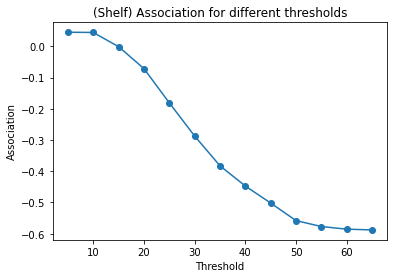

In [50]:
# Very similar to the function above, but this calculates the matrix for the degree instead of attribute
calculate_assortiative_coef = lambda E: (np.trace(E) - np.sum(E @ E.T)) / (1 - np.sum(E @ E.T))
get_i = lambda x, threshold: 1 if x > threshold else 0 # Small function to get the index of the matrix

max_threshold = 70
min_threshold = 5
assosiations = []
thresholds = range(min_threshold, max_threshold, 5)

for i, threshold in enumerate(thresholds):
    # Get dimensions of matrix
    E = np.zeros((2, 2))

    # Fill the matrix
    for edge in shelf_graph.edges:
        # Get the degree of the node at the ends of the edge
        i = get_i(shelf_graph.degree(edge[0]), threshold)
        j = get_i(shelf_graph.degree(edge[1]), threshold)
        E[i, j] += 1
        E[j, i] += 1

    E = E / (2*shelf_graph.number_of_edges())

    # Store the assosiation
    assosiations.append(calculate_assortiative_coef(E))

plt.plot(thresholds, assosiations, "-o")
plt.xlabel("Threshold")
plt.ylabel("Association")
plt.title("(Shelf) Association for different thresholds")
plt.show()

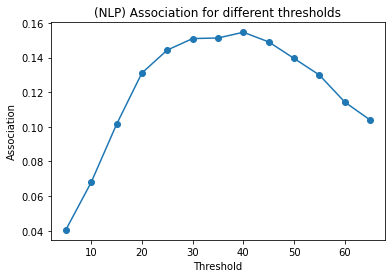

In [52]:
# Very similar to the function above, but this calculates the matrix for the degree instead of attribute
calculate_assortiative_coef = lambda E: (np.trace(E) - np.sum(E @ E.T)) / (1 - np.sum(E @ E.T))
get_i = lambda x, threshold: 1 if x > threshold else 0 # Small function to get the index of the matrix

max_threshold = 70
min_threshold = 5
assosiations = []
thresholds = range(min_threshold, max_threshold, 5)

for i, threshold in enumerate(thresholds):
    # Get dimensions of matrix
    E = np.zeros((2, 2))

    # Fill the matrix
    for edge in NLP_graph.edges:
        # Get the degree of the node at the ends of the edge
        i = get_i(NLP_graph.degree(edge[0]), threshold)
        j = get_i(NLP_graph.degree(edge[1]), threshold)
        E[i, j] += 1
        E[j, i] += 1

    E = E / (2*NLP_graph.number_of_edges())

    # Store the assosiation
    assosiations.append(calculate_assortiative_coef(E))

plt.plot(thresholds, assosiations, "-o")
plt.xlabel("Threshold")
plt.ylabel("Association")
plt.title("(NLP) Association for different thresholds")
plt.show()


For the Shelf Graph we see that there is not really any assortativity, and when the degree becomes large, the assortativity is negative, which indicates that small degree nodes connect to nodes with high degree. 

The NLP Graph has larger assortativity for the degree and is peaking at a degree about 40. This indicates that there is a slight tendency for nodes with above average degree to connect with each other, and vice versa for the below the nodes with average degree. However, this is a very small tendency. 

## Communities
The Louvain algorithm is used to find communities. Next, these communities are evaluated with the modularity measure and we look at how the two graphs' communities differ with mixing matrices. 
- Compute the communities with the Louvain algorithm (stored as *shelf_louvain_05.pickle* and *NLP_louvain_05.pickle*)
- Next, the modularity of the partitions are calculated. 
- This is compared to the modularity of the same graph, but where edges are swapped with the Double Edge Swap Algorithm. 
- At last the two graphs' communities are compared by looking at the mixing matrix to see if they find the same communities. 

### Louvain algorihm to find communities

In [7]:
# Function that applies the Louvain algorithm to a graph, and returns communities
def louvain_communities(graph):
    # Use the louvain method to find communities
    partition = community_louvain.best_partition(graph) 

    # Reformat the partitioning
    communities = {}
    for node, community_id in tqdm(partition.items()):
        communities.setdefault(community_id, []).append(node)

    return list(communities.values())

In [7]:
# Save shelf_louvain_05
folder_path = DATA_PATH
file_name = "shelf_louvain_05.pickle"

if not os.path.exists(os.path.join(folder_path, file_name)):
    # Save the communities
    shelf_louvain = louvain_communities(shelf_graph)
    with open(DATA_PATH + 'shelf_louvain_05.pickle', 'wb') as f:
        pickle.dump(shelf_louvain, f)
else:
    # Load the communities
    shelf_louvain = load_pickle(file_name)

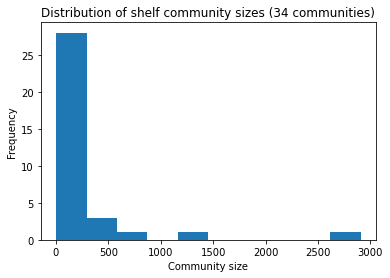

In [55]:
# Print a histogram of the distribution of the communities
shelf_community_sizes = [len(comm) for comm in shelf_louvain]
plt.hist(shelf_community_sizes, bins=10)
plt.xlabel("Community size")
plt.ylabel("Frequency")
plt.title(f"Distribution of shelf community sizes ({len(shelf_louvain)} communities)")
plt.show()

In [8]:
# Save NLP_graph
folder_path = DATA_PATH
file_name = "NLP_louvain_05.pickle"

if not os.path.exists(os.path.join(folder_path, file_name)):
    # Save the network
    NLP_louvain = louvain_communities(NLP_graph)
    with open(DATA_PATH + file_name, 'wb') as f:
        pickle.dump(NLP_louvain, f)
else:
    NLP_louvain = load_pickle(file_name)

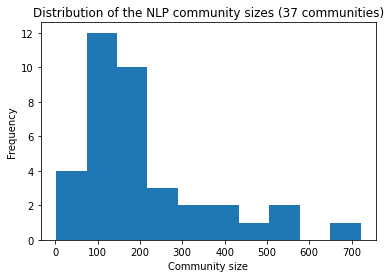

In [57]:
# Print a histogram of the distribution of the communities
nlp_community_sizes = [len(comm) for comm in NLP_louvain]
plt.hist(nlp_community_sizes, bins=10)
plt.xlabel("Community size")
plt.ylabel("Frequency")
plt.title(f"Distribution of the NLP community sizes ({len(NLP_louvain)} communities)")
plt.show()

The Shelf and NLP communities has 34 and 37 communities respectively. The Shelf communities are dominated by two large communities of sizes almost 3000 and 1500, while the NLP communities are more distributed to different sizes, most having about 100-200 members. 

### Modularity
The modularity of a partition of a graph is found with the networkX library.
- For the Shelf Graph the modularity is 0.532
- For the NLP Graph the modularity is 0.529
- We check if these values are significantly different from what is obtain with the same graph, but different edges (with the Double Edge Swap Algorithm)

In [58]:
#Modularity function
def modularity_nx(G, communities):
    """
    Compute the modularity for a communities of a graph.

    Parameters:
        - G: the NetworkX graph
        - communities (list): a list of communities, where each community is a list of node IDs

    Returns:
        - M: the modularity value for the graph
    """

    # Use the louvain method to find communities
    partition = {node: community_id for community_id, nodes in enumerate(communities) for node in nodes}

    # Compute the modularity
    M = community_louvain.modularity(partition, G)

    return M


In [59]:
# Create genre partitions for the graphs 
def create_genre_dict(graph):
    genre_dict = {}
    for node in tqdm(graph.nodes):
        genre = nx.get_node_attributes(graph, 'top_genre')[node]
        try:
            genre_dict[genre].append(node)
        except:
            genre_dict[genre] = [node]
    return genre_dict

shelf_genres = list(create_genre_dict(shelf_graph).values())
NLP_genres = list(create_genre_dict(NLP_graph).values())

100%|██████████| 7661/7661 [00:17<00:00, 431.72it/s]


In [60]:
shelf_modularity = modularity_nx(shelf_graph, shelf_louvain)
shelf_genre_modularity = modularity_nx(shelf_graph, shelf_genres)
NLP_modularity = modularity_nx(NLP_graph, NLP_louvain)
NLP_genre_modularity = modularity_nx(NLP_graph, NLP_genres)

print('The modularity of shelf graph is:', shelf_modularity)
print(f'The modularity of shelf graph is: {shelf_genre_modularity} with the genre partition.')
print('The modularity of NLP graph is:', NLP_modularity)
print(f'The modularity of NLP graph is: {NLP_genre_modularity} with the genre partition.')

The modularity of shelf graph is: 0.5318615935251049
The modularity of shelf graph is: 0.17097521959041537 with the genre partition.
The modularity of NLP graph is: 0.5291186328013848
The modularity of NLP graph is: 0.24624832833305016 with the genre partition.


In [61]:
try:
    shelf_modularities = np.load(DATA_PATH + "shelf_modularities.npy", allow_pickle=True)
except:
    #Set seed in the interest of repeatability
    random.seed(69420)
    #A list that will contain a thousand randomized modularities
    shelf_modularities = []

    # Load the louvain groups if not in memory
    if 'shelf_louvain' not in locals():
        with open(DATA_PATH + 'shelf_louvain_05.pickle', 'rb') as f:
            shelf_louvain = pickle.load(f)

    if 'shelf_graph' not in locals():
        with open(DATA_PATH + 'shelves_network_05.pickle', 'rb') as f:
            shelf_graph = pickle.load(f)

    #The loop that produces a thousand edge swapped datasets, and appends them to rand_modularities
    #Here we use the previously defined modularity and edge_swap functions
    n_swap = len(shelf_graph.edges()) + 1000
    for i in tqdm(range(100)):
        shelf_rand = nx.double_edge_swap(shelf_graph, nswap=n_swap, max_tries=n_swap*10)
        shelf_modularities.append(modularity_nx(shelf_rand, shelf_louvain))

    # Save the date
    np.save(DATA_PATH + "shelf_modularities.npy", shelf_modularities)

In [62]:
try:
    NLP_modularities = np.load(DATA_PATH + "NLP_modularities.npy", allow_pickle=True)
except:
    #Set seed in the interest of repeatability
    random.seed(69420)
    #A list that will contain a thousand randomized modularities
    NLP_modularities = []

    # Load the louvain groups if not in memory
    if 'NLP_louvain' not in locals():
        with open(DATA_PATH + 'NLP_louvain_05.pickle', 'rb') as f:
            NLP_louvain = pickle.load(f)

    if 'NLP_graph' not in locals():
        with open(DATA_PATH + 'NLP_network_05.pickle', 'rb') as f:
            NLP_graph = pickle.load(f)

    #The loop that produces a thousand edge swapped datasets, and appends them to rand_modularities
    #Here we use the previously defined modularity and edge_swap functions
    n_swap = len(shelf_graph.edges()) + 1000
    for i in tqdm(range(200)):
        NLP_rand = nx.double_edge_swap(NLP_graph, nswap=n_swap, max_tries=n_swap*10)
        NLP_modularities.append(modularity_nx(NLP_rand, NLP_louvain))

    # Save the date
    np.save(DATA_PATH + "NLP_modularities.npy", NLP_modularities)



In [63]:
shelf_mean_rand_mods = np.mean(shelf_modularities)
shelf_std_rand_mods = np.std(shelf_modularities)

NLP_mean_rand_mods = np.mean(NLP_modularities)
NLP_std_rand_mods = np.std(NLP_modularities)

print(f"(Shelf) The mean of the {len(shelf_graph.edges()) + 1000} edge swapped modularities is " + str(np.round(shelf_mean_rand_mods, 5)))
print(f"(Shelf) The standard deviation of the {len(shelf_graph.edges()) + 1000} edge swapped modularities is " + str(np.round(shelf_std_rand_mods, 5)))

print()

print("(NLP) The mean of the thousand edge swapped modularities is " + str(np.round(NLP_mean_rand_mods, 5)))
print("(NLP) The standard deviation of the thousand edge swapped modularities is " + str(np.round(NLP_std_rand_mods, 5)))

(Shelf) The mean of the 110627 edge swapped modularities is 0.00789
(Shelf) The standard deviation of the 110627 edge swapped modularities is 0.00193

(NLP) The mean of the thousand edge swapped modularities is -0.00015
(NLP) The standard deviation of the thousand edge swapped modularities is 0.00072


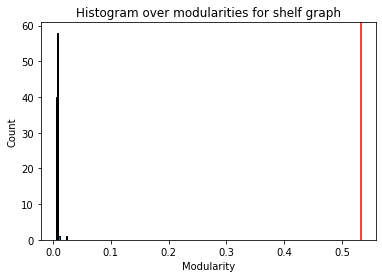

In [64]:
# Plotting a histogram over the distribution values for

plt.hist(shelf_modularities, edgecolor='black')
plt.xlabel('Modularity')
plt.ylabel('Count')
plt.title('Histogram over modularities for shelf graph')
plt.axvline(x=shelf_modularity, color = "red")
plt.show()

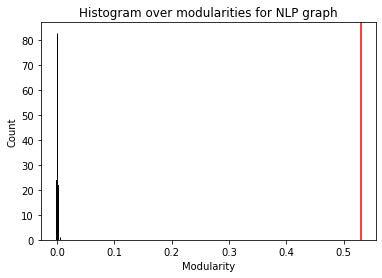

In [65]:
# Plotting a histogram over the distribution values for

plt.hist(NLP_modularities, edgecolor='black')
plt.xlabel('Modularity')
plt.ylabel('Count')
plt.title('Histogram over modularities for NLP graph')
plt.axvline(x=NLP_modularity, color = "red")
plt.show()

As seen in both graphs, it is very unlikely to get a modularity far from 0, and since the modularities of the Shelf Graph and of the NLP Graph are 0.532 and 0.529 respectively, the are significantly different. This is also seen in the figures above. Thus, we have found communities that are very (very) unlikely to have been generated at random.

The genre partitions of the network also has modularities that are far from 0, however, their partitions do not yield as large modularity as the Louvain communities. This indicate that there is some genre structure to the network. We cannot conclude if the Louvain communities and the genre partitions overlap yet, which is way we investigate their mixing matrices below. 

### Mixing matricies
In this section we compare the Shelf Graph communities with the NLP Graph communities, by creating a mixing matrix of their members. To create the mixing matrix we make a matrix of $nc_{shelf} \times nc_{nlp}$ size, where $nc_{graph}$ is the number of communities in that graph. Then for each book add a count in the entry of the matrix corresponding to that books communities. 
We likewise create mixing matrices for each of the graphs compared to the *top_genre* to see if any community encaptures such a genre. 
- Create mixing matrix of the Shelf communities vs. the NLP communities
- Create mixing matrix of the Shelf communities vs. *top_genres*
- Create mixing matrix of the NLP communities vs. *top_genres*

### TODO PUT IN 
We remove communities/genres in the mixing matrix if the number of element in that community/genre is less than 10 books. This is simply to reduce noise in the mixing matrix plots. We do this by removing rows or columns where the row or column sum is less than or equal to 10. 

### TODO 
Again the issue of simplifying the genres to one simple class reduces the usefullness of these plots. If a community has many of books with the genres *religion*, *christian* and *history*, then that community likely has found some underlying topic that is read together, but it is hard to see in these matrices, because they are different categories. We therefore simplify the genres of the mixing matrix to be binary, either a book has the genre *christian* in its genres or it doesn't (here *christian* is just an example). We then see if there is a seperation of the books that contain a genre and books that do not.

In [66]:
# This function creates a mixing matrix for two communities. 
def create_matching_matrix(graph1, graph2):
    # Get the unique groups from both input graphs
    graph1_groups = list(set(graph1.values()))
    graph2_groups = list(set(graph2.values()))

    # Initialize the matrix using nested defaultdicts
    matrix = defaultdict(lambda: defaultdict(int))

    # Set initial values for each combination of groups from both graphs to 0
    for group1 in graph1_groups:
        for group2 in graph2_groups:
            matrix[group1][group2] = 0

    # Iterate through the first graph's items
    for book_id, group1 in graph1.items():
        # Check if the book_id exists in the second graph
        group2 = graph2.get(book_id)
        if group2 is not None:
            # Increment the matrix cell corresponding to the combination of groups
            matrix[group1][group2] += 1

    # Convert the matrix into a pandas DataFrame, transpose it, and fill any missing values with 0
    df = pd.DataFrame(matrix).T.fillna(0)

    return df


In [85]:
def plot_matching_matrix(matching_matrix, title='Matching Matrix', xlabel=None, ylabel=None, size_title=20, threshold=0, genre_save_mode = False, genre_cur = None):
    # Filter the input DataFrame by removing rows and columns with sums less than the specified threshold
    matching_matrix = matching_matrix.loc[matching_matrix.sum(axis=1) >= threshold]
    matching_matrix = matching_matrix.loc[:, (matching_matrix.sum(axis=0) >= threshold)]

    # Sort the filtered matrix rows by their sums in descending order
    matching_matrix = matching_matrix.loc[matching_matrix.sum(axis=1).sort_values(ascending=False).index]

    # Create a new figure and axis with the specified size
    n_columns = len(matching_matrix.columns)
    fig, ax = plt.subplots(figsize=(n_columns, n_columns))

    # Configure Seaborn's settings for font scaling and grid display
    sns.set(font_scale=1.2, rc={"axes.grid": False})

    # Define a colormap using Seaborn's color palette with the "rocket_r" color scheme
    cmap = sns.color_palette("rocket_r", as_cmap=True)

    # Create a NumPy array to store RGBA values for the heatmap
    image_data = np.zeros((len(matching_matrix), n_columns, 4))

    # Iterate through the columns of the DataFrame
    for i, (col_name, col_data) in enumerate(matching_matrix.iteritems()):
        # Normalize the values using TwoSlopeNorm
        norm = TwoSlopeNorm(vmin=0, vcenter=col_data.mean(), vmax=col_data.sum())

        # Assign the corresponding RGBA values from the colormap to image_data
        image_data[:, i] = cmap(norm(col_data.values))[:, :4]

        # Overlay text labels on the cells of the heatmap
        for y, value in enumerate(col_data):
            ax.text(i, y, f'{value:.0f}', ha='center', va='center',
                    color='black' if norm(value) < 0.5 else 'white', fontsize=30)

    # Display the heatmap using imshow() with the image_data array
    ax.imshow(image_data, aspect=1, interpolation='nearest')

    # Set the x and y tick labels
    ax.set_xticks(range(n_columns))
    ax.set_xticklabels(matching_matrix.columns)
    ax.set_yticks(range(len(matching_matrix)))
    ax.set_yticklabels(matching_matrix.index)

    # Customize the plot title, x and y axis labels
    ax.set_title(title, fontsize=size_title)
    ax.set_xlabel(xlabel, fontsize=size_title)
    ax.set_ylabel(ylabel, fontsize=size_title)

    # Adjust the plot layout and display the plot
    fig.tight_layout()
    if genre_save_mode:
        plt.savefig(DATA_PATH + "pictures/" + genre_cur, dpi=300, bbox_inches='tight')
        plt.close()
    else:
        plt.show()

In [68]:
# Getting our three communities to compare them
if not 'complete_book_df' in locals():
    complete_book_df = pd.read_csv(DATA_PATH+ "complete_book_df.csv")
book_genre_dict = complete_book_df.set_index('book_id')['top_genre'].to_dict()

if 'NLP_louvain' not in locals():
        with open(DATA_PATH + 'NLP_louvain_05.pickle', 'rb') as f:
            NLP_louvain = pickle.load(f)
if 'shelf_louvain' not in locals():
        with open(DATA_PATH + 'shelf_louvain_05.pickle', 'rb') as f:
            shelf_louvain = pickle.load(f)

In [69]:
#Converting them to the proper format for confusion matrix
NLP_community_mapping = {}
shelf_community_mapping = {}

for community_id, community in enumerate(NLP_louvain):
    for book in community:
        NLP_community_mapping[book] = str(community_id)

for community_id, community in enumerate(shelf_louvain):
    for book in community:
        shelf_community_mapping[book] = str(community_id)

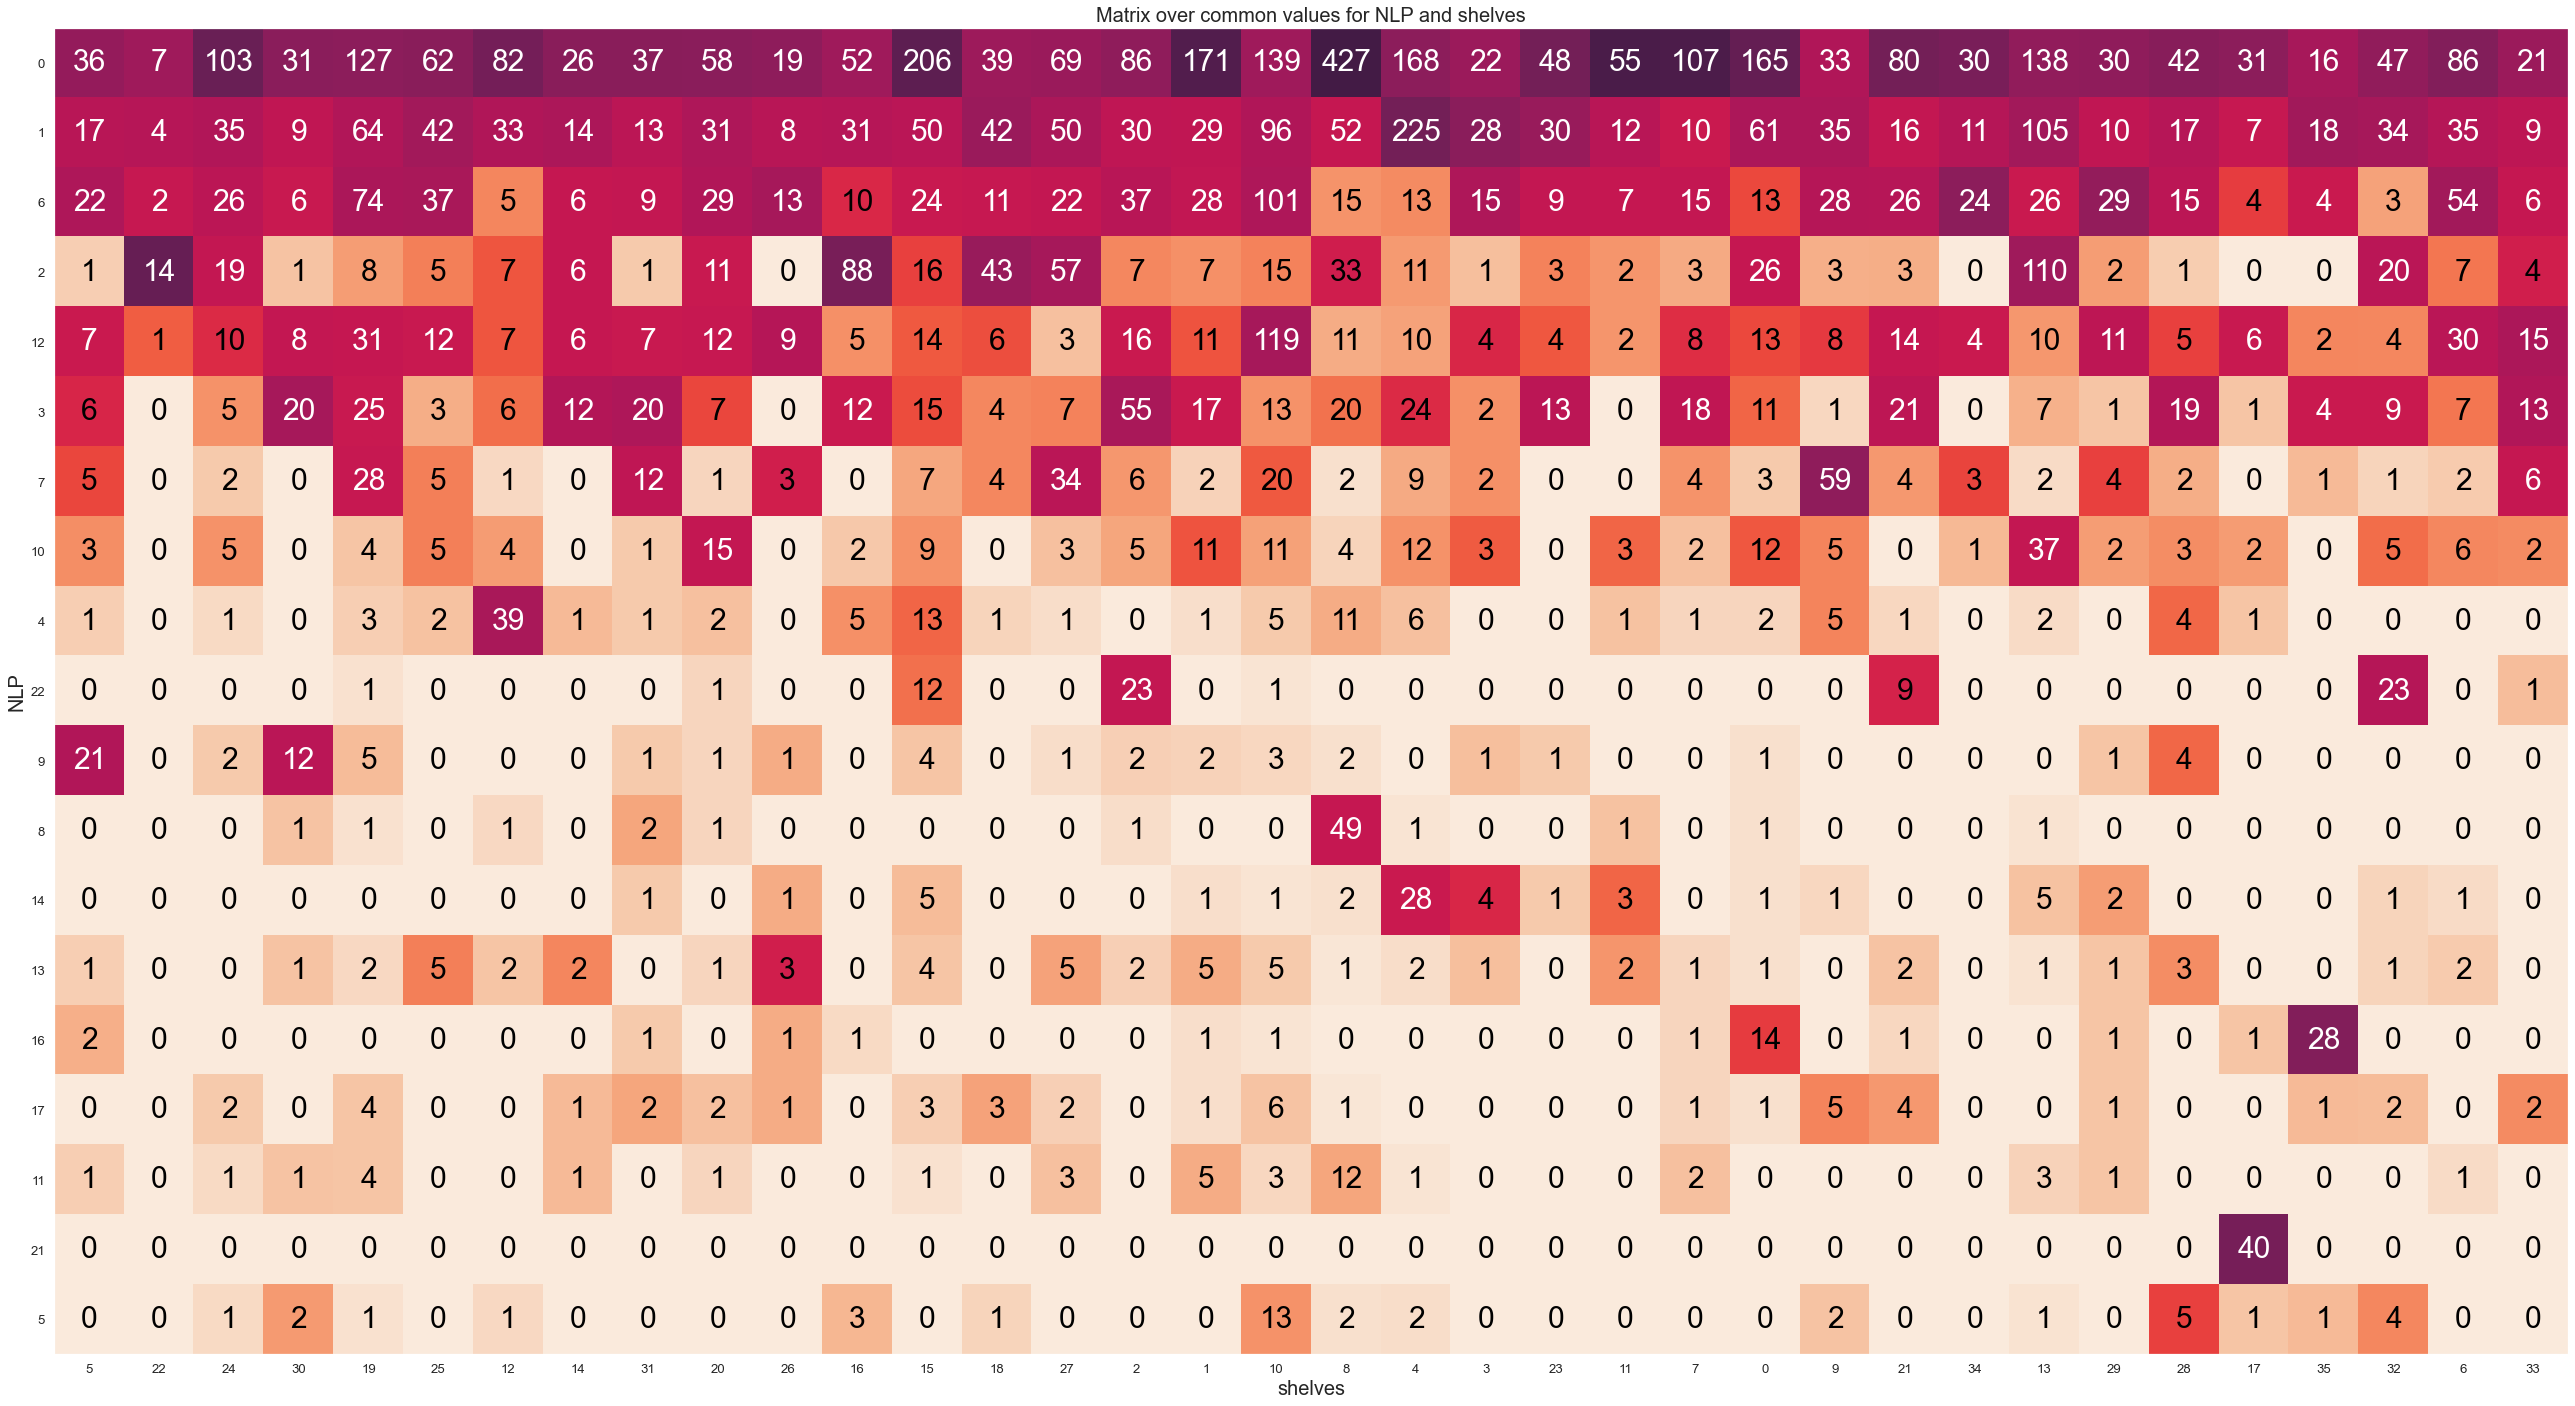

In [74]:
plot_matching_matrix(create_matching_matrix(shelf_community_mapping, NLP_community_mapping), title = "Matrix over common values for NLP and shelves", xlabel = "shelves", ylabel = "NLP",size_title = 20, threshold=20)

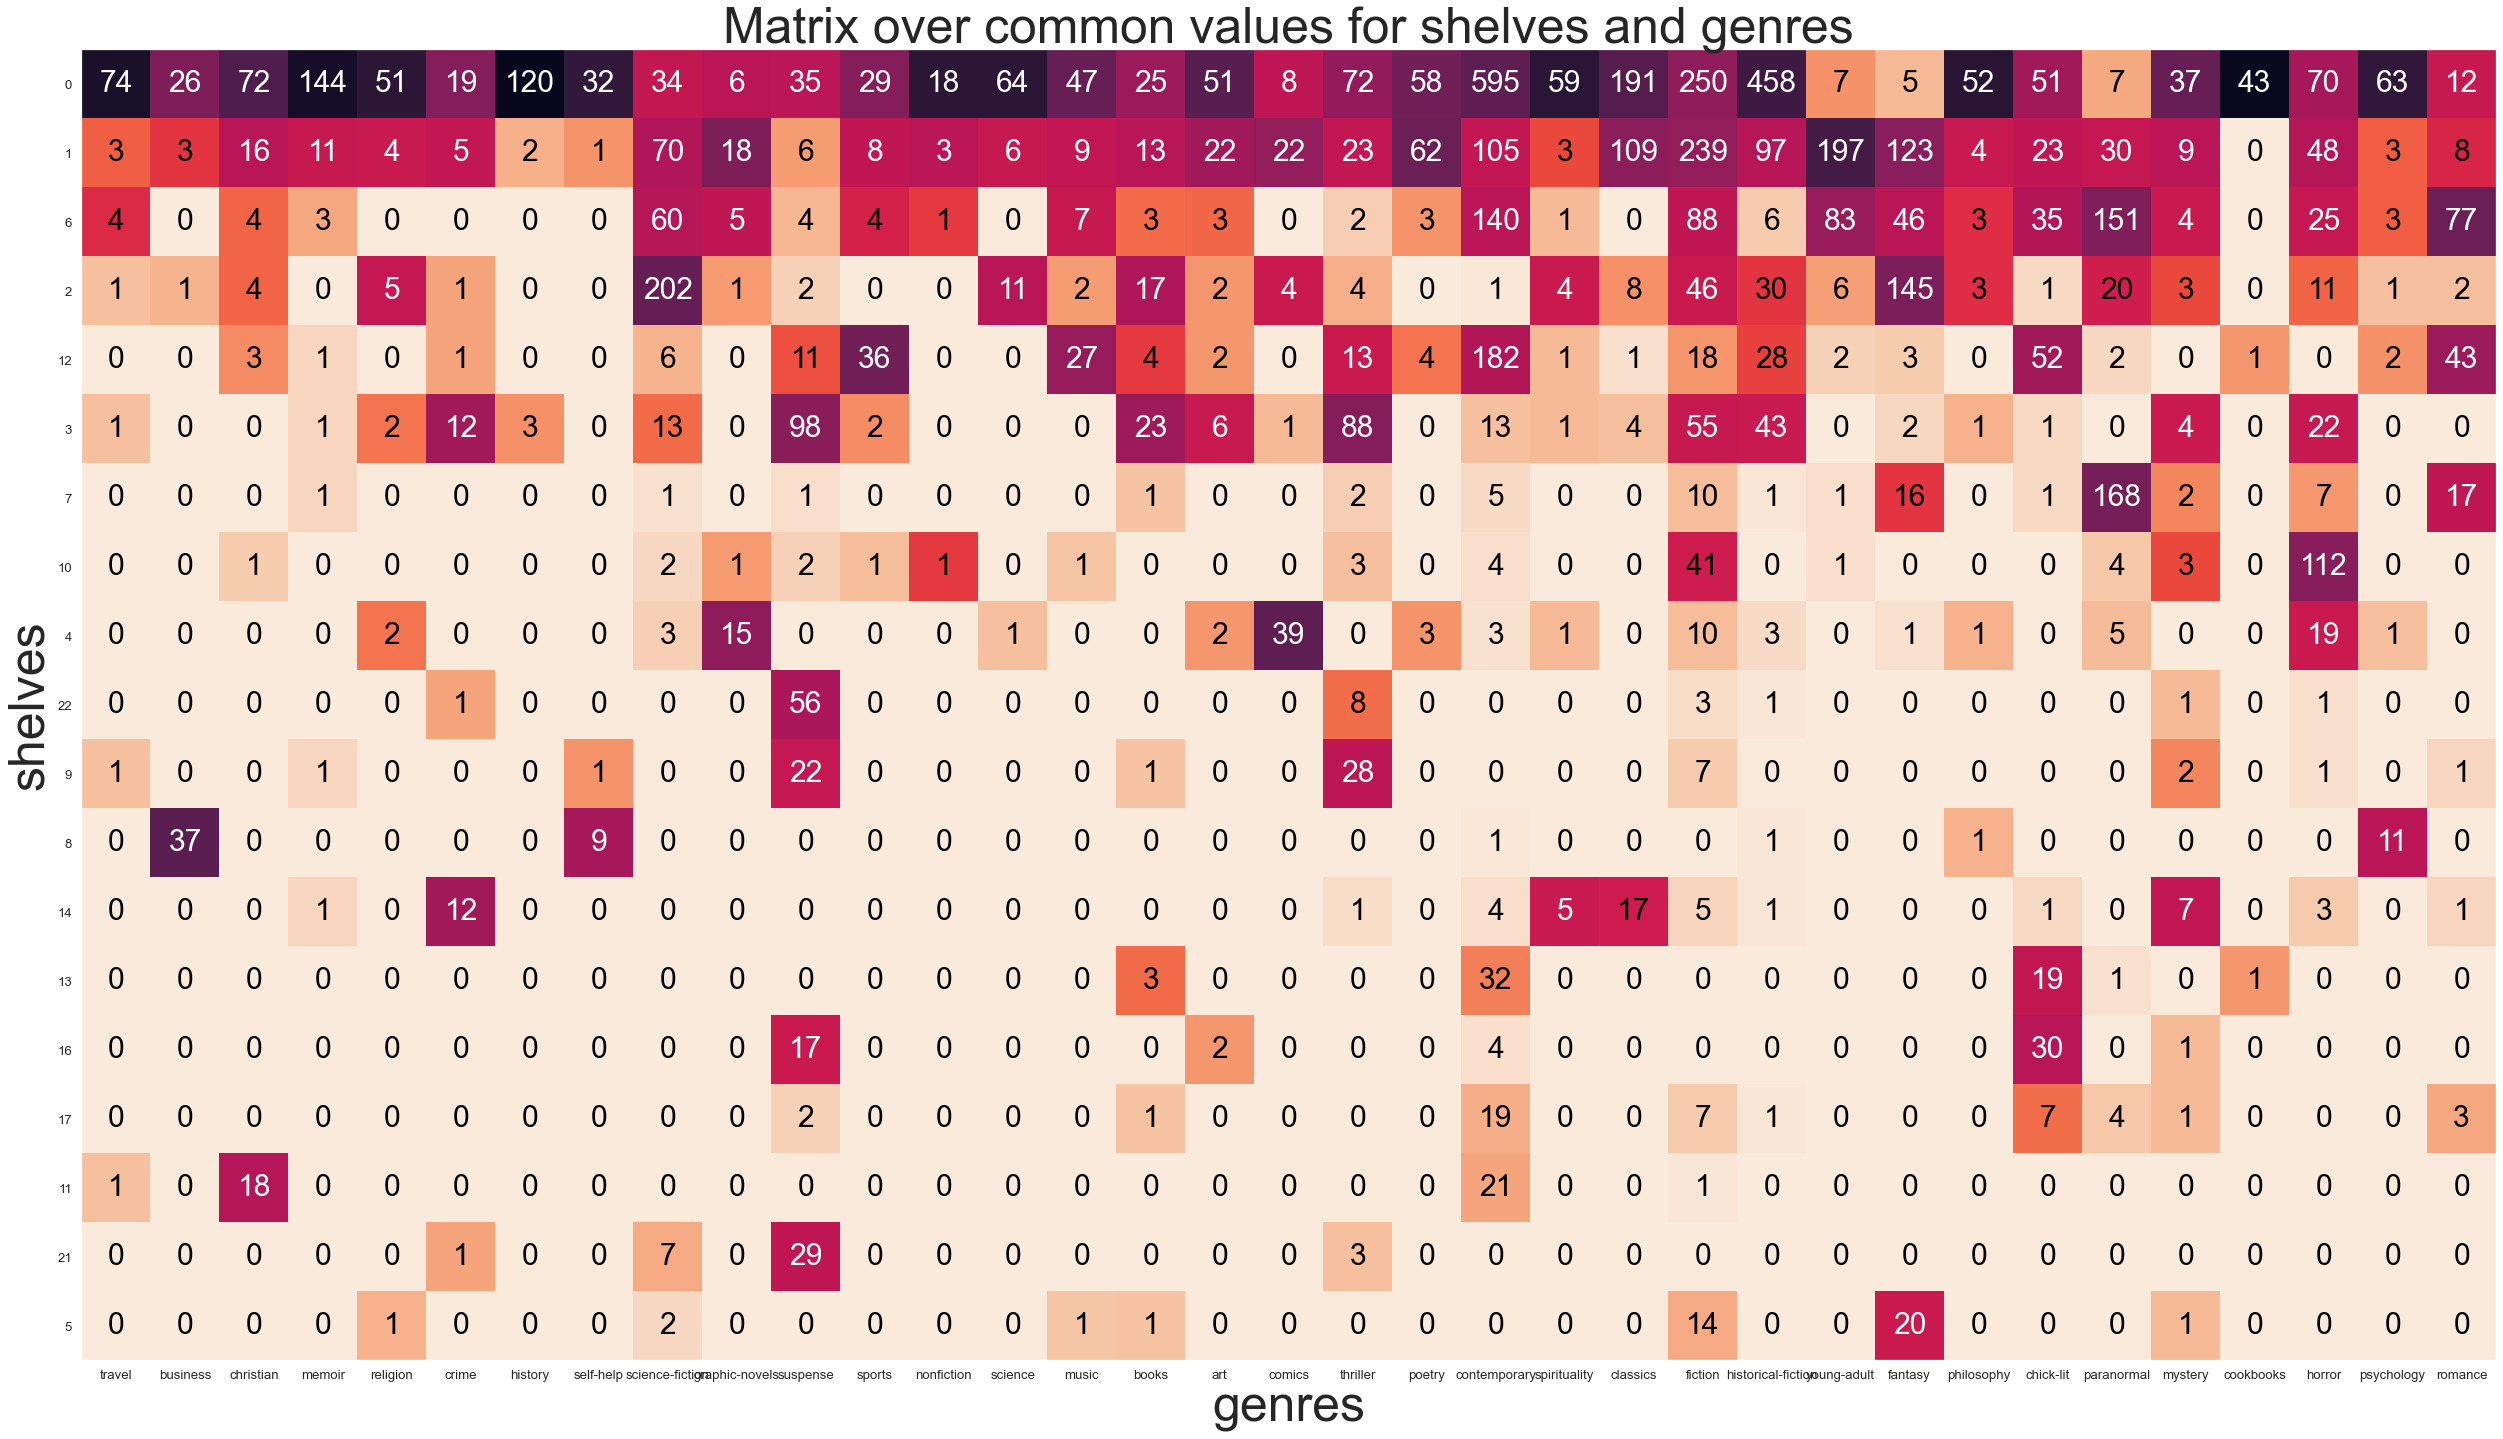

In [75]:
plot_matching_matrix(create_matching_matrix(shelf_community_mapping,book_genre_dict), title = "Matrix over common values for shelves and genres", xlabel = "genres", ylabel = "shelves",size_title = 50, threshold=20)

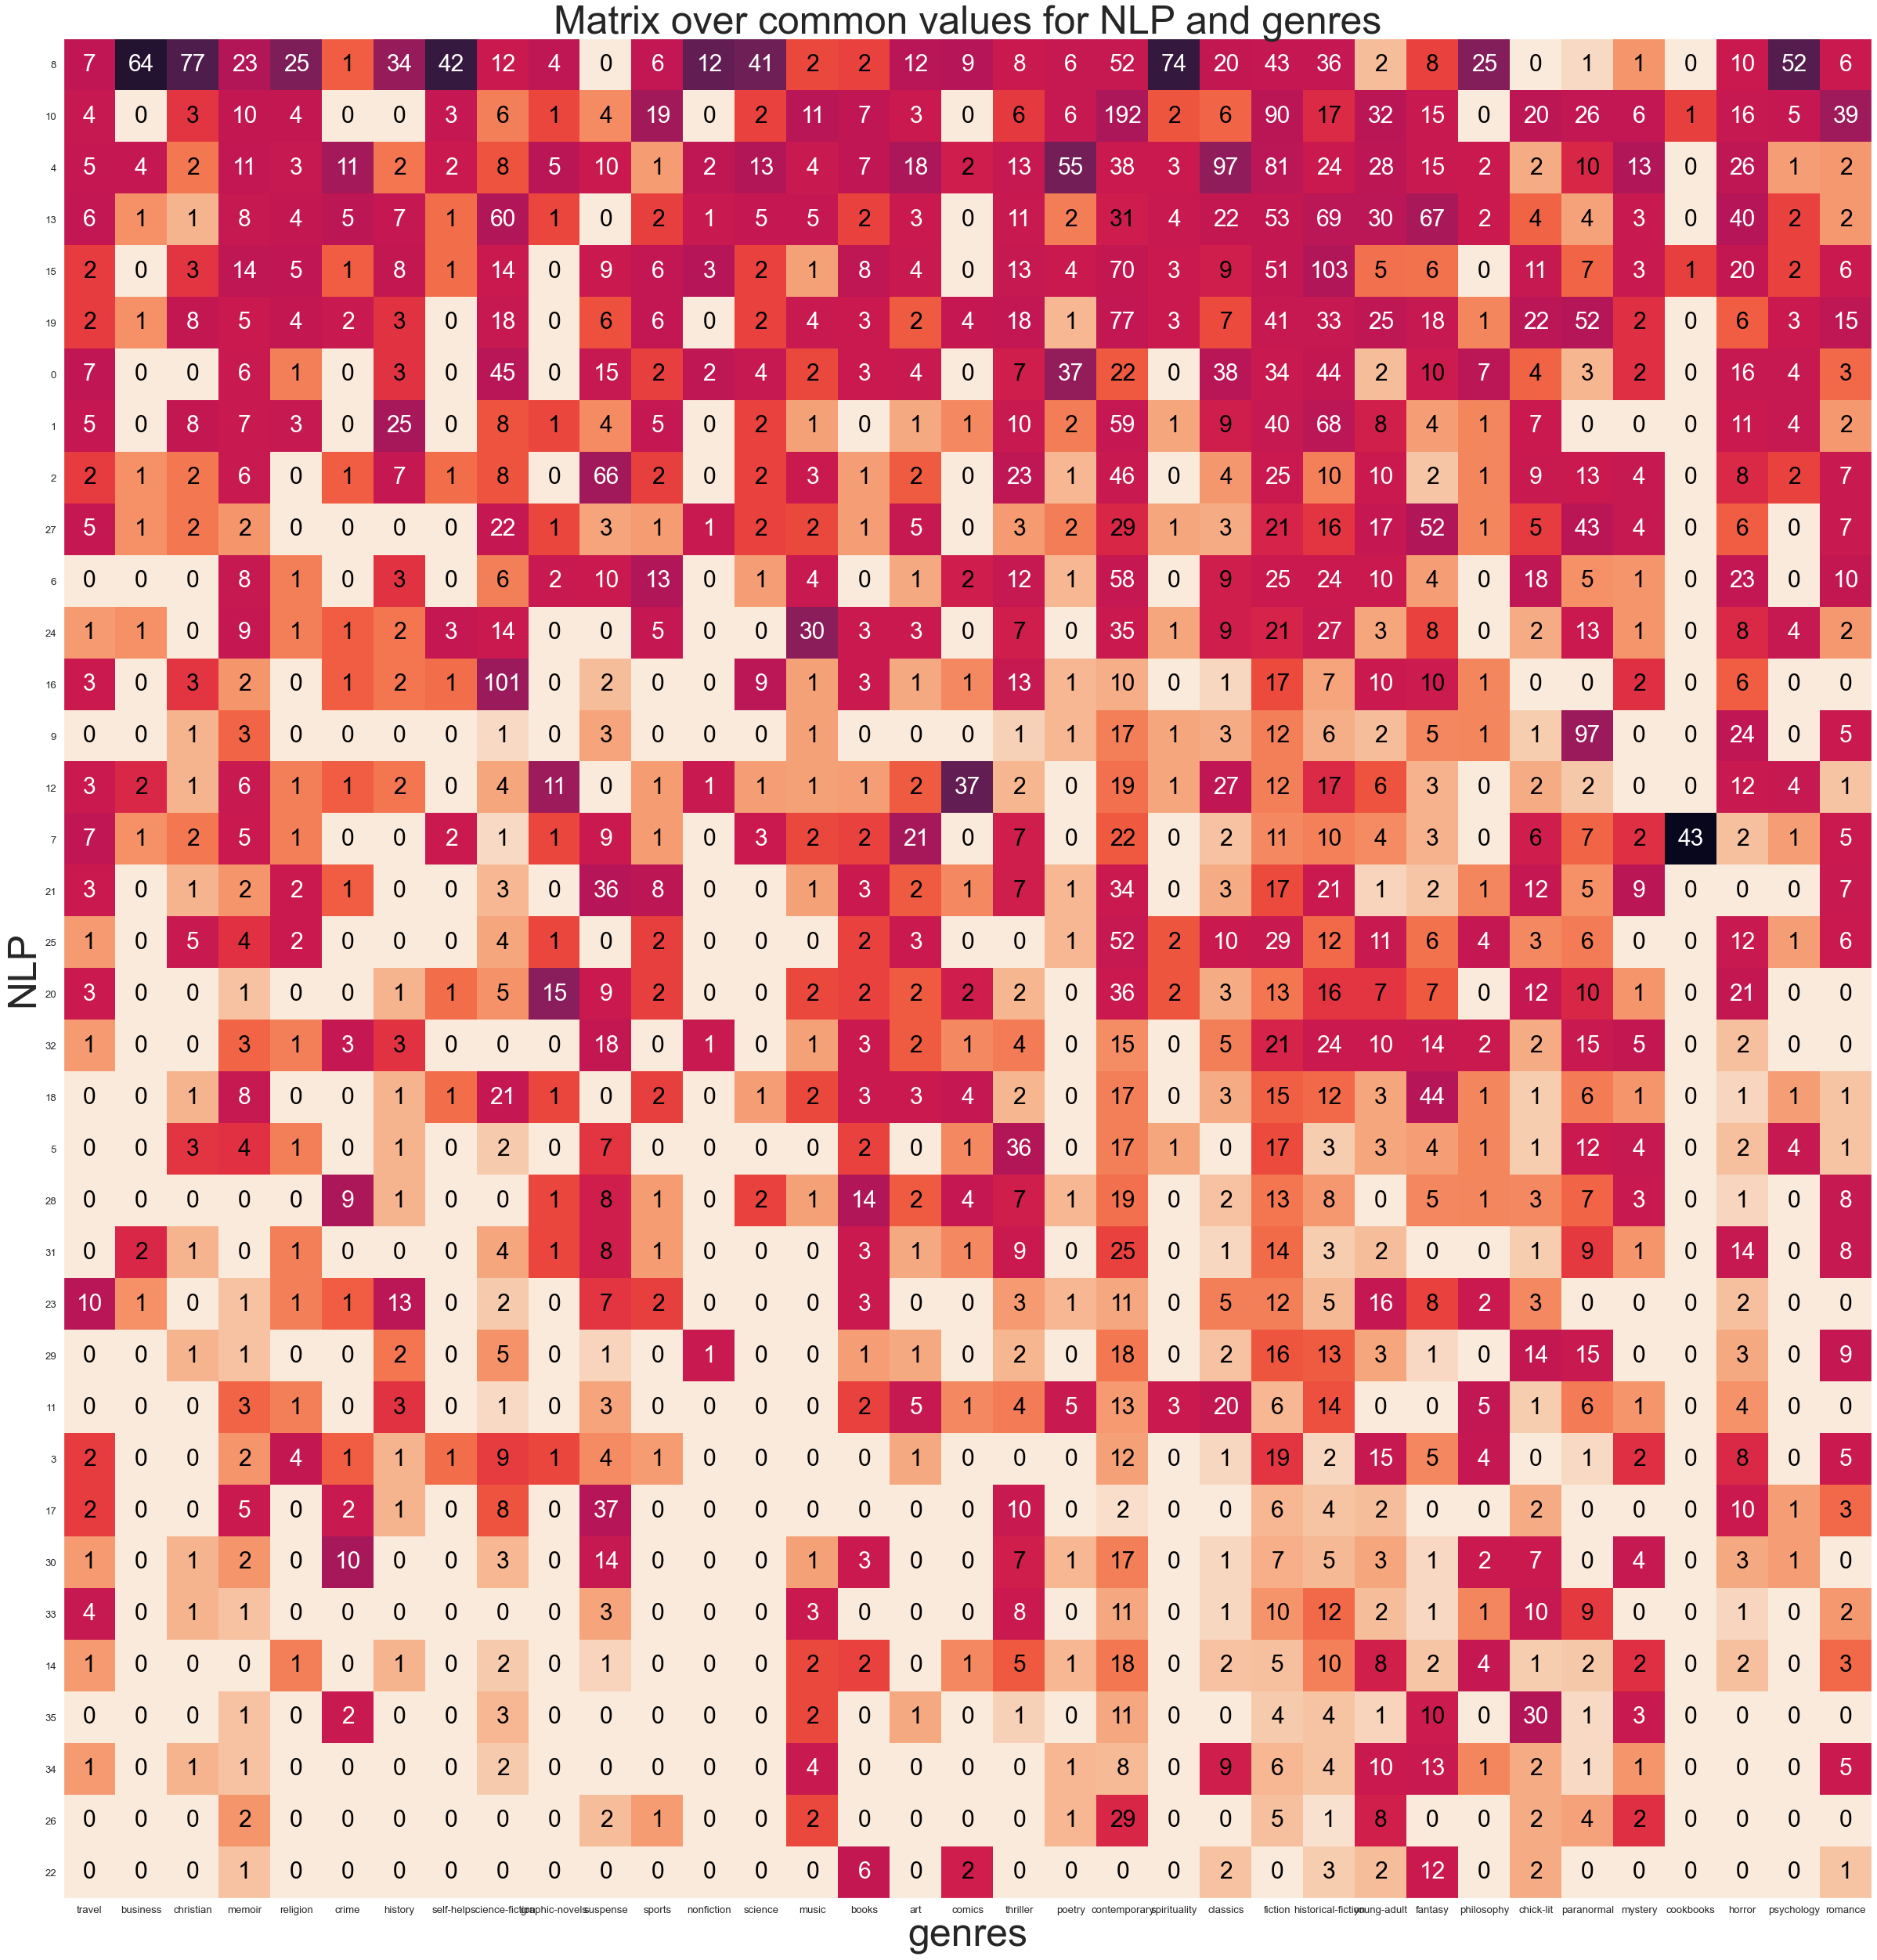

In [76]:
plot_matching_matrix(create_matching_matrix(NLP_community_mapping,book_genre_dict), title = "Matrix over common values for NLP and genres", xlabel = "genres", ylabel = "NLP",size_title = 50, threshold=20)

In [78]:
def create_genre_matrix(book_genres, graph, target_genre):
    graph_groups = list(set(graph.values()))

    # Initialize the matrix using nested defaultdicts
    matrix = defaultdict(lambda: defaultdict(int))

    # Set initial values for each group to 0
    for group in graph_groups:
        matrix[target_genre][group] = 0
        matrix[f'not {target_genre}'][group] = 0

    # Iterate through the graph's items
    for book_id, group in graph.items():
        # Check if the book_id exists in the book_genres dictionary
        genre_str = book_genres.get(book_id)
        if genre_str is not None:
            # Check if the target genre is in the book's genres
            genres = genre_str[1:-1].split(', ')
            has_genre = any(target_genre in genre for genre in genres)

            # Use the target genre as the row key if the book has the genre,
            # otherwise use the "not <target_genre>" as the row key
            row_key = target_genre if has_genre else f'not {target_genre}'

            # Increment the matrix cell corresponding to the group
            matrix[row_key][group] += 1

    # Convert the matrix into a pandas DataFrame, transpose it, and fill any missing values with 0
    df = pd.DataFrame(matrix).T.fillna(0)

    return df

In [86]:
# Compare each single genre with the shelf communities
# Get the list of genres
uniques = complete_book_df['top_genre'].unique()
book_genres = complete_book_df.set_index('book_id')['genres'].to_dict()

for genre in uniques:
    mixing_matrix = create_genre_matrix(book_genres, shelf_community_mapping, genre)
    title = f"The shelf communities and the {genre} genre mixing matrix"
    plot_matching_matrix(mixing_matrix, title=title, xlabel="communities", ylabel="Genre - Not genre", size_title=40, genre_save_mode=True, genre_cur=genre)



It is clear that the communities of the Shelf Graph and of the NLP Graph differ quite a lot, as each row in the above mixing matrix is almost uniformly distributed. Hence, there is basically no correlation between which community a book is in for the Shelf Graph and for the NLP Graph. 
<br><br>
Further we can see that the NLP Graph communities do not contain any specific genres. Only three genres are clearly seperated into single communities spirituality, cookbooks and business. This is a little suprising, as the way we create links in the NLP graph and the way we assign a *top_genre* to a book is the same calculation. This, however, does not yield the the genres as communities. 
<br><br>
At last we see a bit more structure in the way genres appear in the Shelf communities, but the mixing matrix still have a lot of overlap. The largest community contains the majority of *travel*, *self-help*, *christian*, *music*, *contemporary*, *art*, *spirituality*, *science*, *biography*, *psychology*, *history*, *philosophy*, *nonfiction*, *cookbooks*, *classics*, *historical-fiction*, *memoir*, *religion*, which are mostly non-fiction genres. However, this community contains more than a third of the entire graph, thus it contains many books from other genres aswell. 

# Visualize graph

In [87]:
import netwulf

In [21]:
# Load graphs
if 'shelf_graph' not in locals():
    shelf_graph = load_pickle('shelves_network_05.pickle')
    shelf_graph = make_all_nodes_ints(shelf_graph)

if 'NLP_graph' not in locals():
    NLP_graph = load_pickle('NLP_network_05.pickle')
    NLP_graph = make_all_nodes_ints(NLP_graph)

#Load communities
if 'shelf_louvain' not in locals():
    shelf_louvain = load_pickle('shelf_louvain_05.pickle')

if 'NLP_louvain' not in locals():
    NLP_louvain = load_pickle('NLP_louvain_05.pickle')

In [89]:
import matplotlib.colors as mcolors
# List of colors to use for the visualization


# Use netwulf to visualize the communities
def visualize_communities(graph, communities):
    colors = list(mcolors.CSS4_COLORS.values())[20:len(communities) + 20]
    # Create a dictionary that maps nodes to communities
    node_to_community = {}
    for i, community in enumerate(communities):
        for node in community:
            node_to_community[node] = i

    # Add a color attribute to the nodes
    for node in graph.nodes:
        # Add the community number as a node attribute
        graph.nodes[node]["color"] = colors[node_to_community[node]]

    # Visualize the graph with netwulf
    netwulf.visualize(graph, config={"Node color": "color",
                                    'node_size': 50,
                                    'link_width': 0.1,
                                    'link_alpha': 0.01,
                                    'node_size_variation': 0.3,
                                    'zoom': 0.65,
                                    'scale_node_size_by_strength': True,})

In [132]:
visualize_communities(shelf_graph, shelf_louvain)

In [133]:
visualize_communities(NLP_graph, NLP_louvain)

### Colors for genre

In [90]:
def create_genre_dict(graph):
    genre_dict = {}
    for node in tqdm(graph.nodes):
        genre = nx.get_node_attributes(graph, 'top_genre')[node]
        try:
            genre_dict[genre].append(node)
        except:
            genre_dict[genre] = [node]
    return genre_dict

In [91]:
shelf_genre_dict = create_genre_dict(shelf_graph)
NLP_genre_dict = create_genre_dict(NLP_graph)

100%|██████████| 7661/7661 [00:17<00:00, 443.46it/s]


In [92]:
# Use netwulf to visualize the genres
def visualize_genres(graph, genre_dict):
    colors = list(mcolors.CSS4_COLORS.values())[20:len(genre_dict.keys())+20]
    # Create a dictionary that maps nodes to genre
    node_to_genre = {}
    for i, genre in enumerate(genre_dict.keys()):
        for node in genre_dict[genre]:
            node_to_genre[node] = i



    # Add a color attribute to the nodes
    for node in graph.nodes:
        # Add the community number as a node attribute
        graph.nodes[node]["color"] = colors[node_to_genre[node]]

    # Visualize the graph with netwulf
    netwulf.visualize(graph, config={"Node color": "color",
                                    'node_size': 50,
                                    'link_width': 0.1,
                                    'link_alpha': 0.01,
                                    'node_size_variation': 0.3,
                                    'zoom': 0.65,
                                    'scale_node_size_by_strength': True,})

In [137]:
visualize_genres(shelf_graph, shelf_genre_dict)

In [138]:
visualize_genres(NLP_graph, NLP_genre_dict)

# Generate wordclouds

In [16]:
# Find top three books for each community according to degree
def get_top_3_books(graph_type, louvain_groups):
    top_3_books = {}
    # Store the top 3 books by degree for all communities
    for i, community in enumerate(louvain_groups):

        # Get the top 3 books by degree
        sorted_dict = sorted(dict(graph_type.degree(community)).items(), key=lambda x: x[1], reverse=True)
        names = nx.get_node_attributes(graph_type, "title")
        top_3_keys = [k for k, v in sorted_dict[:3]] # Get the ID
        top_3_names = [names[k] for k in top_3_keys] # get the name

        top_3_books[i] = [(top_3_keys[j], top_3_names[j]) for j in range(len(top_3_keys))]
    return top_3_books

In [22]:
# Print the top 3 books for the 9 largest communities
shelf_top_3_books = get_top_3_books(shelf_graph, shelf_louvain)
NLP_top_3_books = get_top_3_books(NLP_graph, NLP_louvain)

shelf_idx_9_largest = np.argsort([-len(community) for community in shelf_louvain])[:9]
NLP_idx_9_largest = np.argsort([-len(community) for community in NLP_louvain])[:9]

#For the shelf graph
for i, community in enumerate(shelf_idx_9_largest):
    print(f"{i+1}. largest community {community}: ")
    for book in shelf_top_3_books[community]:
        print(f"Book: {book[1]}, degree: {shelf_graph.degree(book[0])}")
    print()

#For the shelf graph
for i, community in enumerate(NLP_idx_9_largest):
    print(f"{i+1}. largest community {community}: ")
    for book in NLP_top_3_books[community]:
        print(f"Book: {book[1]}, degree: {NLP_graph.degree(book[0])}")
    print()

1. largest community 0: 
Book: the hunger games, degree: 6355
Book: to kill a mockingbird, degree: 4632
Book: the great gatsby, degree: 3278

2. largest community 1: 
Book: catching fire, degree: 2859
Book: harry potter and the chamber of secrets, degree: 2675
Book: mockingjay, degree: 2558

3. largest community 6: 
Book: city of bones, degree: 1343
Book: the lightning thief, degree: 934
Book: eclipse, degree: 877

4. largest community 2: 
Book: the fellowship of the ring, degree: 755
Book: a game of thrones, degree: 713
Book: ender's game, degree: 411

5. largest community 12: 
Book: twilight, degree: 3566
Book: fifty shades of grey, degree: 384
Book: beautiful disaster, degree: 349

6. largest community 3: 
Book: the da vinci code, degree: 510
Book: angels & demons, degree: 302
Book: a time to kill, degree: 45

7. largest community 7: 
Book: dark lover, degree: 239
Book: halfway to the grave, degree: 185
Book: dead until dark, degree: 158

8. largest community 10: 
Book: the shining,

In [9]:
# Create the TF-IDF matrix for each community 
def create_TF_IDF_community(TF_df, communities, BASE=2):
    """
    Create a TF-IDF matrix for each community
    
    Args: 
        TF_df (pd.DataFrame): TF matrix
        communities (list): List of communities
        BASE (int, optional): Base of the logarithm used in the TF-IDF calculation
    
    Returns:
        TF_IDF_community_df (dict): Dictionary with community as key and TF-IDF matrix as value
    """

    # Mapping from book_id to community
    book_to_community = {}
    for i, community in enumerate(communities):
        for book in community:
            book_to_community[book] = i
    
    # Drop all columns in TF_df that are not in communities, and then all words that appear 0 times
    # Find all columns that are not in communities
    cols_to_drop = []
    for id in TF_df:
        if int(id) not in book_to_community:
            cols_to_drop.append(id)
    # Drop them
    TF_df = TF_df.drop(cols_to_drop, axis=1)
    # Drop empty rows
    TF_df = TF_df.drop(TF_df.index[(TF_df == 0).all(axis=1)]) 


    # Create the TF-IDF matrix for each community
    TF_community_df = pd.DataFrame(index=TF_df.index, columns=list(range(len(communities))))
    TF_community_df = TF_community_df.fillna(0)

    # Go through all books and add the TF scores to the genres of the book
    for book_id in TF_df:
        community = book_to_community[int(book_id)]
        TF_community_df[community] = TF_community_df[community] + TF_df[book_id]
    # Now we have the TF scores for each community, we can calculate the IDF scores

    # Count every time a word appears in a new community. 
    TF_all = TF_community_df.apply(lambda row: (row != 0).sum(), axis=1)
    
    # Get the IDF values for the genres
    IDF_community_dict = {word: np.emath.logn(BASE, len(TF_community_df.columns)/ TF_all[word]) for word in TF_community_df.index}

    # Create the dataframe for the TF-IDF scores for the genres
    TF_IDF_community_df = make_TF_IDF(TF_community_df, IDF_community_dict)

    return TF_IDF_community_df


In [32]:
#Requires TF_IDF for each community

def plot_wordcloud(TF_IDF, graph_communities, top_3_books, community, n_words=100):
    """Make a wordcloud from the TF-IDF scores for a given community
    Args:
        TF_IDF (pandas.DataFrame): Dataframe containing the TF-IDF scores for each word in the corpus
        graph_communities (np.array): List of lists, where the inner list contains all node ids for the given community index
        top_3_books (dict): Dictionary where keys are communities and values are a list of the 3 books with largest degree 
        community (int): The community to make the wordcloud for
        n_words (int, optional): The number of words to include in the wordcloud. Defaults to 100.
    """
    #TODO: missing doc string
    word_cloud = WordCloud().generate_from_frequencies(TF_IDF[community].nlargest(n_words).to_dict()).to_image()
    fig = plt.figure(figsize=(16, 16))

    authors = [author[1] for author in top_3_books[community]]
    plt.title(f"Wordcloud for community {community} size {len(graph_communities[community])}\nTop 3 authors: {authors}")
    plt.imshow(word_cloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()

In [24]:
# Shelf TF-IDF community matrix
try:
    shelf_TF_IDF_df = pd.read_csv(DATA_PATH + "shelf_TF_IDF_df.csv", index_col=0)
except:
    shelf_TF_IDF_df = create_TF_IDF_community(TF_book_df, shelf_louvain)
    shelf_TF_IDF_df.to_csv(DATA_PATH + "shelf_TF_IDF_df.csv")


In [44]:
# Shelf TF-IDF community matrix
try:
    NLP_TF_IDF_df = pd.read_csv(DATA_PATH + "NLP_TF_IDF_df.csv", index_col=0)
except:
    NLP_TF_IDF_df = create_TF_IDF_community(TF_book_df, NLP_louvain)
    NLP_TF_IDF_df.to_csv(DATA_PATH + "NLP_TF_IDF_df.csv")

100%|██████████| 62584/62584 [00:11<00:00, 5599.79it/s]


In [35]:
# Generate all wordclouds for shelf_graph
for i, community in enumerate(shelf_louvain):
    plot_wordcloud(shelf_TF_IDF_df, shelf_louvain, shelf_top_3_books, str(i))

AttributeError: 'TransposedFont' object has no attribute 'getbbox'

In [ ]:
# Generate all wordclouds for NLP_graph
for i, community in enumerate(NLP_louvain):
    plot_wordcloud(NLP_TF_IDF_df, NLP_louvain, NLP_top_3_books, i)